# 1. Extracting and merging pulse oximetry and ABG data from MIMIC-III, MIMIC-IV, eICU

*João Matos, A Ian Wong*

9 Aug, 2023

MIT License

## Instructions

1. Please replace protean-chassis-368116 with your own Google Cloud Project
2. Please replace protean-chassis-368116 with your own Google BigQuery

## Auxiliary tables
* eicu1_pulseOx.cci
* eicu1_pulseOx.pivoted_lab_extended
* eicu1_pulseOx.eicu_pivoted_sofa_xiaoli
* mimiciv_pulseOx.vitals_extended
* mimiciii_pulseOx.pivoted_vital_extended

Available on [GitHub](https://github.com/joamats/pulse-ox-dataset)

## Time Series Variables
[Google Sheets](https://docs.google.com/spreadsheets/d/1W4PS3__-jF3m8OemERsv2r_b9sfACWIr-JQcPxW2A7c/edit#gid=0)

## Patient Characteristics Mappings
[Google Sheets](https://docs.google.com/spreadsheets/d/1Hv_sOd0--6TPYiB3Crjdn_JrIhIazXXJc05mL4GefOU/edit#gid=1877090341)

## Results of this notebook

Running this whole notebook will create two dataframes:

1- *final_df*, the dataframe that we will be sharing as the PulseOx dataset, with the following rules:

* SaO2-SpO2 pairs are captured within 5 minutes
* A range of 70-100% is considered
* Only first pairs per hospital admission are taken

2- *merged_pairs_big*, the dataframe used for the techical validation, with more lenient rules:

* SaO2-SpO2 pairs are captured within 90 minutes
* No range for the saturation is considered
* All pairs per hospital admission are taken


# defines and imports

In [106]:
# replace protean-chassis-368116 with your own project id
%env GOOGLE_CLOUD_PROJECT = protean-chassis-368116

env: GOOGLE_CLOUD_PROJECT=protean-chassis-368116


In [107]:
lower_SO2 = 70
upper_SO2 = 100
lenient_time_window = 90
strict_time_window = 5

In [108]:
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from google.cloud import bigquery

import missingno as msno
import matplotlib.pyplot as plt

import numpy as np

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


#pairs

In [109]:
mimic_iv = {}
mimic_iii = {}
eicu = {}

##mimic-iv

###abgs

In [110]:
%%bigquery mimic_iv_abgs

SELECT *
FROM
(
  SELECT *
  FROM (
    SELECT subject_id, hadm_id, charttime, label, value
    FROM
    (
      -- subquery
        SELECT *
        FROM `physionet-data.mimiciv_hosp.labevents` le
        LEFT JOIN (
          SELECT itemid, label FROM `physionet-data.mimiciv_hosp.d_labitems`
        )  dle2 ON dle2.itemid = le.itemid
        WHERE le.itemid IN (
          SELECT itemid FROM `physionet-data.mimiciv_hosp.d_labitems` WHERE category = "Blood Gas"
          )
    )
  )
  PIVOT (
    ANY_VALUE(value)
    FOR label IN (
      "pH",
      "pCO2",
      "pO2",
      "Oxygen Saturation" as SaO2,
      "Carboxyhemoglobin",
      "Methemoglobin",
      "Specimen Type" as SpecimenType
      )
  )
) pivoted
WHERE
subject_id IS NOT NULL
AND
hadm_id IS NOT NULL
AND
pH IS NOT NULL
AND
pCO2 IS NOT NULL
AND
SaO2 IS NOT NULL
AND
SpecimenType IS NOT NULL
AND
SpecimenType IN ("ART.")
ORDER BY subject_id ASC,  hadm_id ASC, charttime ASC

Query is running:   0%|          |

Downloading:   0%|          |

In [111]:
display(mimic_iv_abgs.head(2))

,subject_id,hadm_id,charttime,pH,pCO2,pO2,SaO2,Carboxyhemoglobin,Methemoglobin,SpecimenType
0,10001884,26184834,2131-01-12 21:04:00,7.38,60,65,90,None,None,ART.
1,10001884,26184834,2131-01-13 02:28:00,7.42,53,69,92,None,None,ART.


In [112]:
for col in ['charttime']:
  mimic_iv_abgs[col] = pd.to_datetime(mimic_iv_abgs[col], errors='coerce')

for col in ['subject_id', 'hadm_id',
            'pH','pCO2','pO2','SaO2'
            ]:
  mimic_iv_abgs[col] = pd.to_numeric(mimic_iv_abgs[col], errors='coerce', downcast = 'integer')

# filters to ensure all minimal ABG data (pH, pCO2, pO2, SaO2) are present
mimic_iv['abgs'] = mimic_iv_abgs[
    mimic_iv_abgs[[
        'subject_id', 'hadm_id', 'charttime',
        'pH', 'pCO2','pO2','SaO2']].notnull().all(axis=1)
]
print(
    'unique subjects with ABGs: ',
    len(mimic_iv['abgs']['subject_id'].unique().tolist())
    )

unique subjects with ABGs:  17846


In [113]:
display(mimic_iv['abgs'].head(2))

,subject_id,hadm_id,charttime,pH,pCO2,pO2,SaO2,Carboxyhemoglobin,Methemoglobin,SpecimenType
0,10001884,26184834,2131-01-12 21:04:00,7.38,60.0,65.0,90.0,None,None,ART.
1,10001884,26184834,2131-01-13 02:28:00,7.42,53.0,69.0,92.0,None,None,ART.


###spo2

In [114]:
%%bigquery mimic_iv_vitals

Select *
FROM (
----
  SELECT subject_id,hadm_id,stay_id, charttime, di2.label, valuenum
  FROM `physionet-data.mimiciv_icu.chartevents` ce
  LEFT JOIN `physionet-data.mimiciv_icu.d_items` di2 ON di2.itemid = ce.itemid
  WHERE ce.itemid IN (
    -- select temp, HR, BP, O2sat
      SELECT itemid
      FROM `physionet-data.mimiciv_icu.d_items` di
      WHERE (
          (linksto = 'chartevents')
          and
          di.category in ('Respiratory', 'Routine Vital Signs')
          and
          di.label in (
              'O2 saturation pulseoxymetry'
              )
          )
    )

  )
  PIVOT (
    avg(valuenum)
    FOR label IN (
            'O2 saturation pulseoxymetry'
      )

  )
ORDER BY subject_id ASC,  hadm_id ASC, charttime ASC

Query is running:   0%|          |

Downloading:   0%|          |

In [115]:
display(mimic_iv_vitals.head(2))

,subject_id,hadm_id,stay_id,charttime,O2 saturation pulseoxymetry
0,10000032,29079034,39553978,2180-07-23 14:13:00,98.0
1,10000032,29079034,39553978,2180-07-23 14:30:00,97.0


In [116]:
for col in ['charttime']:
  mimic_iv_vitals[col] = pd.to_datetime(mimic_iv_vitals[col], errors='coerce')

for col in ['subject_id', 'hadm_id', 'stay_id']:
  mimic_iv_vitals[col] = pd.to_numeric(mimic_iv_vitals[col], errors='coerce', downcast = 'integer')

mimic_iv['vitals'] = mimic_iv_vitals[
    # ensure there are identifiers
    mimic_iv_vitals[[
        'subject_id', 'hadm_id', 'charttime',
        ]].notnull().all(axis=1)
    # and at least one value in vitals
        &
            mimic_iv_vitals[[
            'O2 saturation pulseoxymetry'
        ]].notnull().any(axis=1)

]

mimic_iv['vitals'] = mimic_iv['vitals'].rename(columns={
    'O2 saturation pulseoxymetry':'SpO2',
})


In [117]:
mimic_iv['vitals_withSpO2'] = mimic_iv['vitals'][
    mimic_iv['vitals']['SpO2'].notnull()
].copy()

In [118]:
display(mimic_iv['vitals'].head(2))

,subject_id,hadm_id,stay_id,charttime,SpO2
0,10000032,29079034,39553978,2180-07-23 14:13:00,98.0
1,10000032,29079034,39553978,2180-07-23 14:30:00,97.0


In [119]:
len(mimic_iv['vitals_withSpO2']['subject_id'].unique().tolist())

50880

###merge

In [120]:
mimic_iv['vitals_withSpO2_SaO2'] = mimic_iv['vitals'][
    mimic_iv['vitals']['SpO2'].notnull()
    &
    # ensure vitals are just for patients with ABGs
    mimic_iv['vitals']['subject_id'].isin(mimic_iv['abgs']['subject_id'])
].copy()

In [121]:
display(mimic_iv['vitals_withSpO2_SaO2'].head(2))

,subject_id,hadm_id,stay_id,charttime,SpO2
104,10001884,26184834,37510196,2131-01-11 04:20:00,100.0
105,10001884,26184834,37510196,2131-01-11 05:00:00,98.0


In [122]:
mimic_iv['abgs'] = mimic_iv['abgs'].sort_values(by = [
      'charttime'
      ])
mimic_iv['vitals_withSpO2_SaO2'] = mimic_iv['vitals_withSpO2_SaO2'].sort_values(by = [
      'charttime'
    ])

mimic_iv_ABG_SpO2 = pd.merge_asof(
        left = mimic_iv['abgs'].rename(columns={'charttime':'charttime_abg'}),
        right = mimic_iv['vitals_withSpO2_SaO2'].rename(columns={'charttime':'charttime_vitals'}),
        left_by = 'hadm_id',
        right_by = 'hadm_id',
        left_on = 'charttime_abg',
        right_on = 'charttime_vitals',
        tolerance = pd.Timedelta(seconds = lenient_time_window * 60),
        direction = 'backward',
        suffixes = ('','_todrop'),
        allow_exact_matches = True
    )

mimic_iv_ABG_SpO2.drop(columns = [col for col in mimic_iv_ABG_SpO2.columns if '_todrop' in col], inplace=True)
mimic_iv_ABG_SpO2 = mimic_iv_ABG_SpO2[mimic_iv_ABG_SpO2['charttime_vitals'].notnull()]

cols = mimic_iv_ABG_SpO2.columns.tolist()
cols.insert(2, cols.pop(cols.index('stay_id')))
cols.insert(8, cols.pop(cols.index('SpO2')))
mimic_iv_ABG_SpO2 = mimic_iv_ABG_SpO2[cols]

mimic_iv_ABG_SpO2 = mimic_iv_ABG_SpO2.drop("SpecimenType", axis=1)
mimic_iv_ABG_SpO2['delta_SpO2'] =  (mimic_iv_ABG_SpO2['charttime_vitals'] - mimic_iv_ABG_SpO2['charttime_abg']) \
                                   .dt.total_seconds() / 60

mimic_iv_ABG_SpO2 = mimic_iv_ABG_SpO2.rename(columns={"charttime_abg": "SaO2_timestamp",
                                                      "charttime_vitals": "SpO2_timestamp",
                                                      })


with pd.option_context('display.max_columns',None):
  display(
    mimic_iv_ABG_SpO2.head(2)
  )

mimic_iv['SpO2_SaO2_pairs'] = mimic_iv_ABG_SpO2

del mimic_iv_ABG_SpO2

,subject_id,hadm_id,stay_id,SaO2_timestamp,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_timestamp,delta_SpO2
17,18106347,24305596,30588857,2110-01-11 16:07:00,7.40,37.0,140.0,98.0,100.0,None,None,2110-01-11 16:00:00,-7.0
18,16284044,23864737,36817845,2110-01-13 14:42:00,7.32,37.0,133.0,98.0,100.0,None,None,2110-01-13 14:14:00,-28.0


In [123]:
mimic_iv_pairs = mimic_iv['SpO2_SaO2_pairs'].loc[mimic_iv['SpO2_SaO2_pairs'].delta_SpO2 >= -strict_time_window]

In [124]:
mimic_iv_pairs_cut = mimic_iv_pairs[
    (mimic_iv_pairs['SaO2'] >= lower_SO2)
    &
    (mimic_iv_pairs['SaO2'] <= upper_SO2)
    &
    (mimic_iv_pairs['SpO2'] >= lower_SO2)
    &
    (mimic_iv_pairs['SpO2'] <= upper_SO2)
].copy()

In [125]:
mimic_iv['SpO2_SaO2_first_pairs_5minbefore'] = mimic_iv_pairs_cut.groupby(by = 'hadm_id').first().reset_index()

cols = mimic_iv['SpO2_SaO2_first_pairs_5minbefore'].columns.tolist()
cols.insert(0, cols.pop(cols.index('subject_id')))
mimic_iv['SpO2_SaO2_first_pairs_5minbefore'] = mimic_iv['SpO2_SaO2_first_pairs_5minbefore'][cols]

In [126]:
with pd.option_context('display.max_columns',None):
  display(
    mimic_iv['SpO2_SaO2_first_pairs_5minbefore'].head(2)
  )

,subject_id,hadm_id,stay_id,SaO2_timestamp,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_timestamp,delta_SpO2
0,19836972,20014283,37734890,2158-02-15 06:02:00,7.42,40.0,68.0,92.0,92.0,None,None,2158-02-15 06:00:00,-2.0
1,16534814,20019875,39586196,2144-01-08 20:34:00,7.27,47.0,121.0,97.0,100.0,None,None,2144-01-08 20:30:00,-4.0


##mimic-iii

###abgs

In [127]:
## with specimen type

%%bigquery mimic_iii_abgs

SELECT *
FROM
(
  -- subquery
    SELECT le.SUBJECT_ID, le.HADM_ID, le.CHARTTIME, dle2.LABEL, le.VALUE
    FROM `physionet-data.mimiciii_clinical.labevents` le
    LEFT JOIN (
      SELECT ITEMID, LABEL FROM `physionet-data.mimiciii_clinical.d_labitems` LIMIT 1000
    )  dle2 ON dle2.itemid = le.itemid
    WHERE le.itemid IN (
      SELECT itemid FROM `physionet-data.mimiciii_clinical.d_labitems` WHERE category IN ("Blood Gas", "BLOOD GAS") LIMIT 1000
      )

    ORDER BY SUBJECT_ID ASC, CHARTTIME ASC
)

PIVOT (
    ANY_VALUE(value) -- as avn
    FOR label IN (
      "pH",
      "pCO2",
      "pO2",
      "Oxygen Saturation" as SaO2,
      "Carboxyhemoglobin", "Methemoglobin",
      "SPECIMEN TYPE" as SpecimenType
      )
  ) pivoted

WHERE
HADM_ID IS NOT NULL
AND
SUBJECT_ID IS NOT NULL
AND
pH IS NOT NULL
AND
pCO2 IS NOT NULL
AND
pO2 IS NOT NULL
AND
SaO2 IS NOT NULL
AND
SpecimenType IS NOT NULL
AND
SpecimenType IN ("ART")

Query is running:   0%|          |

Downloading:   0%|          |

In [128]:
display(mimic_iii_abgs.head(2))

,SUBJECT_ID,HADM_ID,CHARTTIME,pH,pCO2,pO2,SaO2,Carboxyhemoglobin,Methemoglobin,SpecimenType
0,3,145834,2101-10-20 21:51:00,7.26,33,287,99,None,None,ART
1,3,145834,2101-10-21 08:46:00,7.42,26,148,99,None,None,ART


In [129]:
for col in ['CHARTTIME']:
  mimic_iii_abgs[col] = pd.to_datetime(mimic_iii_abgs[col], errors='coerce')

for col in ['SUBJECT_ID', 'HADM_ID',
            # 'stay_id' -- doesn't exist for ABGs
            'pH', 'pCO2', 'pO2', 'SaO2'
            ]:
  mimic_iii_abgs[col] = pd.to_numeric(mimic_iii_abgs[col], errors='coerce', downcast = 'integer')

# filters to ensure all minimal ABG data (pH, pCO2, pO2, SaO2) are present
mimic_iii['abgs'] = mimic_iii_abgs[
    mimic_iii_abgs[[
        'SUBJECT_ID', 'HADM_ID', 'CHARTTIME',
        'pH', 'pCO2','pO2','SaO2']].notnull().all(axis=1)
]

print(
    'unique ABGs: ',
    len(mimic_iii['abgs'])
    )

mimic_iii['abgs'] = mimic_iii_abgs[
    mimic_iii_abgs['SaO2'].notnull()
    & mimic_iii_abgs['pH'].notnull()
    & mimic_iii_abgs['pO2'].notnull()
    ].copy() # require SaO2 and all

display(mimic_iii['abgs'].head(2))


unique ABGs:  95509


,SUBJECT_ID,HADM_ID,CHARTTIME,pH,pCO2,pO2,SaO2,Carboxyhemoglobin,Methemoglobin,SpecimenType
0,3,145834,2101-10-20 21:51:00,7.26,33.0,287.0,99.0,None,None,ART
1,3,145834,2101-10-21 08:46:00,7.42,26.0,148.0,99.0,None,None,ART


###spo2

In [130]:
%%bigquery mimic_iii_vitals

-- open vitals and pivot
Select *
FROM (
----
  SELECT subject_id,hadm_id,icustay_id, charttime, di2.label, valuenum
  FROM `physionet-data.mimiciii_clinical.chartevents` ce
  LEFT JOIN `physionet-data.mimiciii_clinical.d_items` di2 ON di2.itemid = ce.itemid
  WHERE ce.itemid IN (
    -- select temp, HR, BP, O2sat
      SELECT itemid
      FROM `physionet-data.mimiciii_clinical.d_items` di
      WHERE (
          (linksto = 'chartevents')
          and
          di.category in ('Respiratory', 'Routine Vital Signs')
          and
          di.label in (
              'O2 saturation pulseoxymetry'
              )
          )
    )

----
  )
  PIVOT (
    avg(valuenum)
    FOR label IN (
            'O2 saturation pulseoxymetry'
      )

  )
ORDER BY subject_id ASC,  hadm_id ASC, charttime ASC

Query is running:   0%|          |

Downloading:   0%|          |

In [131]:
for col in ['charttime']:
  mimic_iii_vitals[col] = pd.to_datetime(mimic_iii_vitals[col], errors='coerce')

for col in ['subject_id', 'hadm_id', 'icustay_id']:
  mimic_iii_vitals[col] = pd.to_numeric(mimic_iii_vitals[col], errors='coerce', downcast = 'integer')


mimic_iii['vitals'] = mimic_iii_vitals[
    # ensure there are identifiers
    mimic_iii_vitals[[
        'subject_id', 'hadm_id', 'charttime',
        ]].notnull().all(axis=1)
    # and at least one value in vitals
        &
            mimic_iii_vitals[[
            'O2 saturation pulseoxymetry'
        ]].notnull().any(axis=1)

]

mimic_iii['vitals'] = mimic_iii['vitals'].rename(columns={
    'O2 saturation pulseoxymetry':'SpO2'
})

mimic_iii_vitals = mimic_iii_vitals.rename(columns={
    'O2 saturation pulseoxymetry':'SpO2'
})

mimic_iii['vitals'] = mimic_iii_vitals[
    mimic_iii_vitals['SpO2'].notnull()
  ]


In [132]:
display(mimic_iii['vitals'].head(2))

,subject_id,hadm_id,icustay_id,charttime,SpO2
0,23,124321,234044,2157-10-21 12:07:00,100.0
1,23,124321,234044,2157-10-21 13:00:00,99.0


###merge

In [133]:
mimic_iii['vitals_withSpO2_SaO2'] = mimic_iii['vitals'][
    mimic_iii['vitals']['SpO2'].notnull()
    &
    # ensure vitals are just for patients with ABGs
    mimic_iii['vitals']['subject_id'].isin(mimic_iii['abgs']['SUBJECT_ID'])
].copy()

mimic_iii['abgs'] = mimic_iii['abgs'].loc[mimic_iii['abgs']['HADM_ID'].notnull()]

mimic_iii_ABG_SpO2 = pd.merge_asof(
        left = mimic_iii['abgs'].sort_values(by=['CHARTTIME']).rename(columns={'CHARTTIME':'charttime_abg'}),
        right = mimic_iii['vitals_withSpO2_SaO2'].sort_values(by=['charttime']).rename(columns={'charttime':'charttime_vitals'}),
        left_by = 'HADM_ID',
        right_by = 'hadm_id',
        left_on = 'charttime_abg',
        right_on = 'charttime_vitals',
        tolerance = pd.Timedelta(seconds = lenient_time_window * 60),
        direction = 'backward',
        suffixes = ('','_todrop'),
        allow_exact_matches = True
    )

mimic_iii_ABG_SpO2.drop(columns = [col for col in mimic_iii_ABG_SpO2.columns if '_todrop' in col], inplace=True)
mimic_iii_ABG_SpO2 = mimic_iii_ABG_SpO2[mimic_iii_ABG_SpO2['charttime_vitals'].notnull()]

cols = mimic_iii_ABG_SpO2.columns.tolist()
cols.insert(2, cols.pop(cols.index('icustay_id')))
cols.insert(8, cols.pop(cols.index('SpO2')))
mimic_iii_ABG_SpO2 = mimic_iii_ABG_SpO2[cols]

mimic_iii_ABG_SpO2 = mimic_iii_ABG_SpO2.drop(["SpecimenType", "subject_id", "hadm_id"], axis=1)
mimic_iii_ABG_SpO2['delta_SpO2'] =  (mimic_iii_ABG_SpO2['charttime_vitals'] - mimic_iii_ABG_SpO2['charttime_abg']) \
                                   .dt.total_seconds() / 60

mimic_iii_ABG_SpO2 = mimic_iii_ABG_SpO2.rename(columns={"charttime_abg": "SaO2_timestamp",
                                                        "charttime_vitals": "SpO2_timestamp",
                                                        })

with pd.option_context('display.max_columns',None, 'display.max_rows', 5):
  display(
    mimic_iii_ABG_SpO2.head(2)
  )

cols = mimic_iii_ABG_SpO2.columns.tolist()
cols.insert(0, cols.pop(cols.index('SUBJECT_ID')))
mimic_iii_ABG_SpO2 = mimic_iii_ABG_SpO2[cols]

mimic_iii['SpO2_SaO2_pairs'] = mimic_iii_ABG_SpO2

del mimic_iii_ABG_SpO2

,SUBJECT_ID,HADM_ID,icustay_id,SaO2_timestamp,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_timestamp,delta_SpO2
17,84585,182054,245641,2100-08-03 01:28:00,7.37,36.0,43.0,79.0,100.0,None,0,2100-08-03 01:15:00,-13.0
18,84585,182054,245641,2100-08-03 02:11:00,7.38,37.0,51.0,88.0,98.0,None,None,2100-08-03 02:00:00,-11.0


In [134]:
mimic_iii_pairs = mimic_iii['SpO2_SaO2_pairs'].loc[mimic_iii['SpO2_SaO2_pairs'].delta_SpO2 >= -strict_time_window]

In [135]:
mimic_iii_pairs_cut = mimic_iii_pairs[
    (mimic_iii_pairs['SaO2'] >= lower_SO2)
    &
    (mimic_iii_pairs['SaO2'] <= upper_SO2)
    &
    (mimic_iii_pairs['SpO2'] >= lower_SO2)
    &
    (mimic_iii_pairs['SpO2'] <= upper_SO2)
].copy()

In [136]:
len(mimic_iii_pairs_cut)

1271

In [137]:
mimic_iii['SpO2_SaO2_first_pairs_5minbefore'] = mimic_iii_pairs_cut.groupby(by = 'HADM_ID').first().reset_index()


In [138]:
display(mimic_iii['SpO2_SaO2_first_pairs_5minbefore'].head(2))

,HADM_ID,SUBJECT_ID,icustay_id,SaO2_timestamp,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_timestamp,delta_SpO2
0,100068,9889,204988,2192-01-14 16:01:00,7.39,47.0,126.0,97.0,100.0,None,None,2192-01-14 16:00:00,-1.0
1,100166,45647,223205,2200-02-26 22:01:00,7.37,41.0,107.0,97.0,100.0,None,None,2200-02-26 22:00:00,-1.0


##eicu-crd


###abgs

In [139]:
%%bigquery

DROP TABLE IF EXISTS `protean-chassis-368116.eicu1_pulseOx.eicu_abgs`;
CREATE TABLE `protean-chassis-368116.eicu1_pulseOx.eicu_abgs` AS

# SELECT *
# FROM (
    SELECT *
    FROM --- `protean-chassis-368116.racial_bias.mimiciv_labevents_abgs`
    (
      -- subquery
      SELECT lab.patientunitstayid, labresultoffset, labresult, labname, labresultrevisedoffset
      FROM `physionet-data.eicu_crd.lab` lab
      LEFT JOIN `physionet-data.eicu_crd.patient` pat
      ON pat.patientunitstayid = lab.patientunitstayid
      WHERE lab.labtypeid = 7
      ORDER BY
        lab.patientunitstayid ASC,
        lab.labresultoffset ASC,
        lab.labresultrevisedoffset ASC
      # LIMIT 10000 # comment if you want to just do a test run
    )
   PIVOT (
    avg(labresult) -- as avn
    FOR labname IN (
      "pH",
      "paCO2",
      "paO2",
      "O2 Sat (%)" as SaO2,
      "Carboxyhemoglobin",
      "Methemoglobin"

      )
  )
# ) pivoted
WHERE
pH IS NOT NULL
AND
paCO2 IS NOT NULL
AND
paO2 IS NOT NULL
AND
SaO2 IS NOT NULL

Query is running:   0%|          |

""


In [140]:

%%bigquery eicu_abgs

SELECT *
FROM `protean-chassis-368116.eicu1_pulseOx.eicu_abgs`

Query is running:   0%|          |

Downloading:   0%|          |

In [141]:
eicu['abgs'] = eicu_abgs
display(eicu['abgs'].head(2))
del eicu_abgs

,patientunitstayid,labresultoffset,labresultrevisedoffset,pH,paCO2,paO2,SaO2,Carboxyhemoglobin,Methemoglobin
0,800936,3196,3214,0.0,0.0,0.0,0.0,NaN,NaN
1,1556807,4763,4763,0.0,0.0,0.0,0.0,NaN,0.0


###spo2

In [142]:
%%bigquery

DROP TABLE IF EXISTS `protean-chassis-368116.eicu1_pulseOx.eicu_vitals_withSaO2`;
CREATE TABLE `protean-chassis-368116.eicu1_pulseOx.eicu_vitals_withSaO2` AS

SELECT
  patientunitstayid,
  observationoffset,
  sao2 as spo2, # really spo2, since it's taken with the vitals
FROM `physionet-data.eicu_crd.vitalperiodic` vp
WHERE
    (
        patientunitstayid in (
        # select patients who have MetHgb, CarboxyHgb
        SELECT distinct(patientunitstayid)
        FROM `physionet-data.eicu_crd.lab`
        WHERE
            labtypeid = 7  # blood gases
            AND
            labname in ('O2 Sat (%)') # only patients with O2 sat
        ORDER BY patientunitstayid # , labresultoffset LIMIT 1000
        )
    )
    AND
    vp.sao2 IS NOT NULL  -- a lot of data doesn't have "sao2"
ORDER BY patientunitstayid, observationoffset

## warning, number too large, currently crashes

Query is running:   0%|          |

""


###merge

In [143]:
%%bigquery eicu_abgs_vitals

SELECT pat.uniquepid, SaO2_SpO2.*, patient.*
FROM (
  -- join ABGs to vitals and impose
  -- https://stackoverflow.com/questions/20136990/how-to-cross-join-in-big-query-using-intervals

  SELECT abgs.*,
    vitals.patientunitstayid as patientunitstayid_vitals,
    vitals.observationoffset,
    vitals.spo2,
  FROM `protean-chassis-368116.eicu1_pulseOx.eicu_abgs` abgs
  CROSS JOIN `protean-chassis-368116.eicu1_pulseOx.eicu_vitals_withSaO2` vitals
  WHERE
    abgs.patientunitstayid = vitals.patientunitstayid
    AND
    vitals.observationoffset <= (abgs.labresultoffset)
  ORDER BY
    abgs.patientunitstayid ASC,
    abgs.labresultoffset ASC,
    vitals.observationoffset ASC
  -- LIMIT 1000
) SaO2_SpO2
LEFT JOIN `physionet-data.eicu_crd.patient` AS pat
ON pat.patientunitstayid = SaO2_SpO2.patientunitstayid
LEFT JOIN (
  SELECT DISTINCT patientunitstayid as patientunitstayid_patient, patienthealthsystemstayid
  FROM `physionet-data.eicu_crd.patient`
) patient ON patient.patientunitstayid_patient = SaO2_SpO2.patientunitstayid

WHERE TRUE
  # save last row in cross join
  QUALIFY ROW_NUMBER() OVER (
    PARTITION BY SaO2_SpO2.patientunitstayid, SaO2_SpO2.labresultoffset
    # PARTITION BY patient.patienthealthsystemstayid, SaO2_SpO2.labresultoffset
    ORDER BY SaO2_SpO2.observationoffset DESC) = 1

ORDER BY SaO2_SpO2.patientunitstayid, labresultoffset

Query is running:   0%|          |

Downloading:   0%|          |

In [144]:
eicu_abgs_vitals = eicu_abgs_vitals.loc[eicu_abgs_vitals.labresultoffset - eicu_abgs_vitals.observationoffset <= lenient_time_window ]

In [145]:
# takes the first ABG for each
eicu_abgs_vitals = eicu_abgs_vitals.rename(columns={
    'spo2':'SpO2',
})

eicu['SpO2_SaO2_pairs'] = eicu_abgs_vitals

eicu_pairs = eicu_abgs_vitals.loc[eicu_abgs_vitals.labresultoffset - eicu_abgs_vitals.observationoffset <= strict_time_window]

In [146]:
eicu_pairs = eicu_pairs.loc[eicu_pairs['SaO2'] >= lower_SO2]
eicu_pairs = eicu_pairs.loc[eicu_pairs['SaO2'] <= upper_SO2]
eicu_pairs = eicu_pairs.loc[eicu_pairs['SpO2'] >= lower_SO2]
eicu_pairs = eicu_pairs.loc[eicu_pairs['SpO2'] <= upper_SO2]


eicu_abgs_vitals_first = eicu_pairs \
                        .sort_values(by=['patienthealthsystemstayid', 'labresultoffset']) \
                        .groupby(by=['patienthealthsystemstayid']) \
                        .first().reset_index()

display(eicu_abgs_vitals_first.head(2))

,patienthealthsystemstayid,uniquepid,patientunitstayid,labresultoffset,labresultrevisedoffset,pH,paCO2,paO2,SaO2,Carboxyhemoglobin,Methemoglobin,patientunitstayid_vitals,observationoffset,SpO2,patientunitstayid_patient
0,128973,002-8979,141233,24,1675,7.34,33.0,337.0,99.0,0.2,0.3,141233,21,100,141233
1,129157,002-65302,141451,45,53,7.34,46.0,80.0,93.0,0.8,1.5,141451,44,95,141451


In [147]:
eicu_abgs_vitals_first = eicu_abgs_vitals_first.drop(["patientunitstayid_patient",
                                                      "patientunitstayid_vitals",
                                                      "labresultrevisedoffset"],
                                                      axis=1)

eicu_abgs_vitals_first = eicu_abgs_vitals_first.rename(columns={
                                                                "labresultoffset": "SaO2_offset",
                                                                "observationoffset": "SpO2_offset",
                                                                "paO2": "pO2", "paCO2": "pCO2"
                                                                })

eicu_abgs_vitals_first['delta_SpO2'] =  (eicu_abgs_vitals_first['SpO2_offset'] - eicu_abgs_vitals_first['SaO2_offset'])

cols = eicu_abgs_vitals_first.columns.tolist()
cols.insert(0, cols.pop(cols.index('uniquepid')))
cols.insert(2, cols.pop(cols.index('patientunitstayid')))
cols.insert(8, cols.pop(cols.index('SpO2')))
eicu_abgs_vitals_first = eicu_abgs_vitals_first[cols]


eicu['SpO2_SaO2_first_pairs_5minbefore'] = eicu_abgs_vitals_first

del eicu_abgs_vitals_first

In [148]:
display(eicu['SpO2_SaO2_first_pairs_5minbefore'].head(2))

,uniquepid,patienthealthsystemstayid,patientunitstayid,SaO2_offset,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_offset,delta_SpO2
0,002-8979,128973,141233,24,7.34,33.0,337.0,99.0,100,0.2,0.3,21,-3
1,002-65302,129157,141451,45,7.34,46.0,80.0,93.0,95,0.8,1.5,44,-1


In [149]:
eicu['SpO2_SaO2_first_pairs_5minbefore'].uniquepid.nunique()

39401

## upload

In [150]:
def create_table_id(project_id, dataset_id, tab_id):

  return f"{project_id}.{dataset_id}.{tab_id}"


In [151]:
import pandas_gbq

project_id = "protean-chassis-368116"
dataset_id = "pairs"

final_tables = {"mimic_iv":  mimic_iv ['SpO2_SaO2_first_pairs_5minbefore'],
                "mimic_iii": mimic_iii['SpO2_SaO2_first_pairs_5minbefore'],
                "eicu":      eicu     ['SpO2_SaO2_first_pairs_5minbefore']
}

for t_name, t_df in final_tables.items():

  table_id = create_table_id(project_id, dataset_id, t_name)
  t_df.to_gbq(table_id, project_id=project_id, if_exists='replace')


100%|██████████| 1/1 [00:00<00:00, 1521.33it/s]


#time_series

###functions

In [152]:
def get_vars_df(sheet_id, gid):

  return pd.read_csv(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}')

In [153]:
def create_subquery(pairs_table,
                    sao2_time,
                    var_type,
                    var_name,
                    var_new_name,
                    var_window_low_hr,
                    var_window_upper_hr,
                    var_source_table,
                    var_foreign_key,
                    var_timestamp):



    if sao2_time == "SaO2_timestamp":
      time_diff = f"TIMESTAMP_DIFF(CAST(table.{var_timestamp} AS TIMESTAMP), CAST(pairs.{sao2_time} AS TIMESTAMP), MINUTE)"

    elif sao2_time == "SaO2_offset":
      time_diff = f"table.{var_timestamp} - pairs.{sao2_time} "

    return f"""
    {var_type}_{var_name} AS (
      SELECT * FROM (
        SELECT
          pairs.{var_foreign_key},
          {var_name},
          pairs.{sao2_time},
          {time_diff} AS delta_{var_type}_{var_new_name},
          ROW_NUMBER() OVER(PARTITION BY pairs.{var_foreign_key}, pairs.{sao2_time}
                            ORDER BY ABS({time_diff}) ASC) AS seq
        FROM `{pairs_table}` pairs
        LEFT JOIN `{var_source_table}` AS table
        ON table.{var_foreign_key} = pairs.{var_foreign_key}
        AND {var_name} IS NOT NULL
        AND {time_diff} BETWEEN {var_window_low_hr} * 60 AND {var_window_upper_hr} * 60
      )
      WHERE seq = 1
    )
    """

In [154]:
def create_complete_query(pairs_table, vars_df, sao2_time):

  subquery_list = []

  # Iterate over each row in df
  for index, row in vars_df.iterrows():

      subquery = create_subquery(pairs_table,
                                 sao2_time,
                                 row['var_type'],
                                 row['var_name'],
                                 row['var_new_name'],
                                 row['var_window_low_hr'],
                                 row['var_window_upper_hr'],
                                 row['var_source_table'],
                                 row['var_foreign_key'],
                                 row['var_timestamp'])
      subquery_list.append(subquery)

  # Now you have your subqueries, join them into one string
  subquery_string = ",\n\n".join(subquery_list)

  final_query = f"""
  WITH
  {subquery_string}
  SELECT
      pairs.*,
      {" , ".join([f"{row.var_type}_{row.var_name}.delta_{row.var_type}_{row.var_new_name}, {row.var_type}_{row.var_name}.{row.var_name} AS {row.var_type}_{row.var_new_name}" for index, row in vars_df.iterrows()])}
  FROM `{pairs_table}` pairs
  {" ".join([f"LEFT JOIN {row.var_type}_{row.var_name} ON {row.var_type}_{row.var_name}.{row.var_foreign_key} = pairs.{row.var_foreign_key} AND {row.var_type}_{row.var_name}.{sao2_time} = pairs.{sao2_time}" for index, row in vars_df.iterrows()])}
  """
  return final_query


###mimic-iv

In [155]:
sao2_time = "SaO2_timestamp"
pairs_table = "protean-chassis-368116.pairs.mimic_iv"

sheet_id = "1W4PS3__-jF3m8OemERsv2r_b9sfACWIr-JQcPxW2A7c"
gid = "0"
vars_df = get_vars_df(sheet_id, gid)

query = create_complete_query(pairs_table, vars_df, sao2_time)

client = bigquery.Client(project='protean-chassis-368116')
mimic_iv_df = client.query(query).to_dataframe()


In [156]:
with pd.option_context('display.max_columns',None, 'display.max_rows',10):
  display(mimic_iv_df.head(2))

,subject_id,hadm_id,stay_id,SaO2_timestamp,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_timestamp,delta_SpO2,delta_vitals_heart_rate,vitals_heart_rate,delta_vitals_resp_rate,vitals_resp_rate,delta_vitals_mbp_ni,vitals_mbp_ni,delta_vitals_sbp_ni,vitals_sbp_ni,delta_vitals_dbp_ni,vitals_dbp_ni,delta_vitals_mbp_i,vitals_mbp_i,delta_vitals_sbp_i,vitals_sbp_i,delta_vitals_dbp_i,vitals_dbp_i,delta_vitals_tempc,vitals_tempc,delta_cbc_hemoglobin,cbc_hemoglobin,delta_cbc_hematocrit,cbc_hematocrit,delta_cbc_mch,cbc_mch,delta_cbc_mchc,cbc_mchc,delta_cbc_mcv,cbc_mcv,delta_cbc_platelet,cbc_platelet,delta_cbc_rbc,cbc_rbc,delta_cbc_rdw,cbc_rdw,delta_cbc_wbc,cbc_wbc,delta_coag_fibrinogen,coag_fibrinogen,delta_coag_inr,coag_inr,delta_coag_pt,coag_pt,delta_coag_ptt,coag_ptt,delta_bmp_sodium,bmp_sodium,delta_bmp_potassium,bmp_potassium,delta_bmp_chloride,bmp_chloride,delta_bmp_bicarbonate,bmp_bicarbonate,delta_bmp_bun,bmp_bun,delta_bmp_creatinine,bmp_creatinine,delta_bmp_glucose,bmp_glucose,delta_bmp_aniongap,bmp_aniongap,delta_bmp_calcium,bmp_calcium,delta_bmp_lactate,bmp_lactate,delta_hfp_alt,hfp_alt,delta_hfp_alp,hfp_alp,delta_hfp_ast,hfp_ast,delta_hfp_bilirubin_total,hfp_bilirubin_total,delta_hfp_bilirubin_direct,hfp_bilirubin_direct,delta_hfp_albumin,hfp_albumin,delta_others_ck_cpk,others_ck_cpk,delta_others_ck_mb,others_ck_mb,delta_others_ld_ldh,others_ld_ldh,delta_sofa_past_overall_24hr,sofa_past_overall_24hr,delta_sofa_past_coagulation_24hr,sofa_past_coagulation_24hr,delta_sofa_past_liver_24hr,sofa_past_liver_24hr,delta_sofa_past_cardiovascular_24hr,sofa_past_cardiovascular_24hr,delta_sofa_past_cns_24hr,sofa_past_cns_24hr,delta_sofa_past_renal_24hr,sofa_past_renal_24hr,delta_sofa_future_overall_24hr,sofa_future_overall_24hr,delta_sofa_future_coagulation_24hr,sofa_future_coagulation_24hr,delta_sofa_future_liver_24hr,sofa_future_liver_24hr,delta_sofa_future_cardiovascular_24hr,sofa_future_cardiovascular_24hr,delta_sofa_future_cns_24hr,sofa_future_cns_24hr,delta_sofa_future_renal_24hr,sofa_future_renal_24hr
0,15316479,20288987,34659358,2131-10-14 04:00:00+00:00,7.39,47.0,60.0,91.0,98.0,None,None,2131-10-14 04:00:00+00:00,0.0,0,100.0,0,31.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,0,81.0,0,132.0,0,59.0,-240,37.330000000,-91,10.3,-91,30.1,-91,31.4,-91,34.2,-91,92.0,-91,194.0,-91,3.28,-91,13.0,-91,15.4,-1020,191.0,-91,1.1,-91,12.4,-91,26.4,-91,140.0,-91,4.1,-91,105.0,-91,26.0,-91,17.0,-91,1.1,-91,101.0,-91,13.0,-91,8.4,0,0.7,-3925,22.0,-3925,48.0,-3925,15.0,-3925,0.7,<NA>,NaN,-3925,3.5,-5100,88.0,-5100,3.0,<NA>,NaN,-60,5,-60,0,-60,0,-60,1,-60,1,-60,0,1500,3,1500,0,1500,0,1500,1,1500,0,1500,0
1,11697485,20673985,32375378,2157-07-15 23:00:00+00:00,7.34,42.0,60.0,86.0,95.0,None,None,2157-07-15 23:00:00+00:00,0.0,0,96.0,0,14.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,0,64.0,0,98.0,0,49.0,<NA>,None,-382,8.8,-382,27.2,-382,29.9,-382,32.4,-382,92.0,-382,180.0,-382,2.95,-382,16.3,-382,10.2,-429,259.0,-382,1.3,-382,14.5,-382,29.2,-382,139.0,-382,5.0,-382,111.0,-382,24.0,-382,17.0,-382,1.2,-950,106.0,-382,9.0,-950,9.8,0,1.2,-4995,11.0,-4995,47.0,-4995,13.0,-4995,0.6,<NA>,NaN,-4995,3.9,-5298,86.0,-2345,3.0,<NA>,NaN,-60,5,-60,0,-60,0,-60,1,-60,0,-60,1,1500,7,1500,1,1500,0,1500,1,1500,1,1500,1


###mimic-iii

In [157]:
sao2_time = "SaO2_timestamp"
pairs_table = "protean-chassis-368116.pairs.mimic_iii"

sheet_id = "1W4PS3__-jF3m8OemERsv2r_b9sfACWIr-JQcPxW2A7c"
gid = "1691545663"
vars_df = get_vars_df(sheet_id, gid)

query = create_complete_query(pairs_table, vars_df, sao2_time)

client = bigquery.Client(project='protean-chassis-368116')
mimic_iii_df = client.query(query).to_dataframe()

In [158]:
with pd.option_context('display.max_columns',None, 'display.max_rows',10):
  display(mimic_iii_df.head(2))

,HADM_ID,SUBJECT_ID,icustay_id,SaO2_timestamp,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_timestamp,delta_SpO2,delta_vitals_heart_rate,vitals_heart_rate,delta_vitals_resp_rate,vitals_resp_rate,delta_vitals_mbp_ni,vitals_mbp_ni,delta_vitals_sbp_ni,vitals_sbp_ni,delta_vitals_dbp_ni,vitals_dbp_ni,delta_vitals_mbp_i,vitals_mbp_i,delta_vitals_sbp_i,vitals_sbp_i,delta_vitals_dbp_i,vitals_dbp_i,delta_vitals_tempc,vitals_tempc,delta_cbc_hemoglobin,cbc_hemoglobin,delta_cbc_hematocrit,cbc_hematocrit,delta_cbc_mch,cbc_mch,delta_cbc_mchc,cbc_mchc,delta_cbc_mcv,cbc_mcv,delta_cbc_platelet,cbc_platelet,delta_cbc_rbc,cbc_rbc,delta_cbc_rdw,cbc_rdw,delta_cbc_wbc,cbc_wbc,delta_coag_fibrinogen,coag_fibrinogen,delta_coag_inr,coag_inr,delta_coag_pt,coag_pt,delta_coag_ptt,coag_ptt,delta_bmp_sodium,bmp_sodium,delta_bmp_potassium,bmp_potassium,delta_bmp_chloride,bmp_chloride,delta_bmp_bicarbonate,bmp_bicarbonate,delta_bmp_bun,bmp_bun,delta_bmp_creatinine,bmp_creatinine,delta_bmp_glucose,bmp_glucose,delta_bmp_aniongap,bmp_aniongap,delta_bmp_calcium,bmp_calcium,delta_bmp_lactate,bmp_lactate,delta_hfp_alt,hfp_alt,delta_hfp_alp,hfp_alp,delta_hfp_ast,hfp_ast,delta_hfp_bilirubin_total,hfp_bilirubin_total,delta_hfp_bilirubin_direct,hfp_bilirubin_direct,delta_hfp_albumin,hfp_albumin,delta_others_ck_cpk,others_ck_cpk,delta_others_ck_mb,others_ck_mb,delta_others_ld_ldh,others_ld_ldh,delta_sofa_past_overall_24hr,sofa_past_overall_24hr,delta_sofa_past_coagulation_24hr,sofa_past_coagulation_24hr,delta_sofa_past_liver_24hr,sofa_past_liver_24hr,delta_sofa_past_cardiovascular_24hr,sofa_past_cardiovascular_24hr,delta_sofa_past_cns_24hr,sofa_past_cns_24hr,delta_sofa_past_renal_24hr,sofa_past_renal_24hr,delta_sofa_future_overall_24hr,sofa_future_overall_24hr,delta_sofa_future_coagulation_24hr,sofa_future_coagulation_24hr,delta_sofa_future_liver_24hr,sofa_future_liver_24hr,delta_sofa_future_cardiovascular_24hr,sofa_future_cardiovascular_24hr,delta_sofa_future_cns_24hr,sofa_future_cns_24hr,delta_sofa_future_renal_24hr,sofa_future_renal_24hr
0,141497,65815,265074,2137-06-03 05:45:00+00:00,7.42,40.0,58.0,91.0,94.0,None,None,2137-06-03 05:45:00+00:00,0.0,0,98.0,0,27.0,0,64.0,-15,105.0,-15,57.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,-165,35.333333,<NA>,NaN,<NA>,NaN,-165,30.5,-165,33.6,-165,91.0,-165,497.0,-165,3.40,-165,14.5,-165,11.1,-3675,649.0,-165,1.9,-165,20.5,-165,39.2,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,-165,27.0,-165,0.8,<NA>,NaN,-165,17.0,0,1.16,0,1.6,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,-165,159.0,-165,12.0,-2681,373.0,-105,2,-105,0,-105,0,-105,1,-105,1,-105,0,1515,6,1515,0,1515,0,1515,1,1515,1,1515,0
1,179716,80632,244636,2123-02-23 17:45:00+00:00,7.31,50.0,62.0,89.0,92.0,None,None,2123-02-23 17:45:00+00:00,0.0,0,67.0,0,18.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,0,85.0,0,121.0,0,64.0,<NA>,NaN,-427,10.2,-427,31.0,-339,31.6,-339,33.3,-339,95.0,-339,153.0,-339,4.64,-339,14.9,-339,12.9,<NA>,NaN,-339,1.3,-339,14.8,-339,30.0,-427,142.0,0,3.7,-427,126.0,<NA>,NaN,-339,9.0,-339,0.4,0,101.0,-339,8.0,0,1.18,-325,1.8,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,-105,2,-105,0,-105,0,-105,0,-105,0,-105,0,1515,7,1515,1,1515,0,1515,1,1515,2,1515,0


###eicu-crd


In [159]:
sao2_time = "SaO2_offset"
pairs_table = "protean-chassis-368116.pairs.eicu"

sheet_id = "1W4PS3__-jF3m8OemERsv2r_b9sfACWIr-JQcPxW2A7c"
gid = "326954316"
vars_df = get_vars_df(sheet_id, gid)

query = create_complete_query(pairs_table, vars_df, sao2_time)

client = bigquery.Client(project='protean-chassis-368116')
eicu_df = client.query(query).to_dataframe()

In [160]:
with pd.option_context('display.max_columns', None, 'display.max_rows',10):
  display(eicu_df.head(2))

,uniquepid,patienthealthsystemstayid,patientunitstayid,SaO2_offset,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_offset,delta_SpO2,delta_vitals_heart_rate,vitals_heart_rate,delta_vitals_resp_rate,vitals_resp_rate,delta_vitals_mbp_ni,vitals_mbp_ni,delta_vitals_sbp_ni,vitals_sbp_ni,delta_vitals_dbp_ni,vitals_dbp_ni,delta_vitals_mbp_i,vitals_mbp_i,delta_vitals_sbp_i,vitals_sbp_i,delta_vitals_dbp_i,vitals_dbp_i,delta_vitals_tempc,vitals_tempc,delta_cbc_hemoglobin,cbc_hemoglobin,delta_cbc_hematocrit,cbc_hematocrit,delta_cbc_mch,cbc_mch,delta_cbc_mchc,cbc_mchc,delta_cbc_mcv,cbc_mcv,delta_cbc_platelet,cbc_platelet,delta_cbc_rbc,cbc_rbc,delta_cbc_rdw,cbc_rdw,delta_cbc_wbc,cbc_wbc,delta_coag_fibrinogen,coag_fibrinogen,delta_coag_inr,coag_inr,delta_coag_pt,coag_pt,delta_coag_ptt,coag_ptt,delta_bmp_sodium,bmp_sodium,delta_bmp_potassium,bmp_potassium,delta_bmp_chloride,bmp_chloride,delta_bmp_bicarbonate,bmp_bicarbonate,delta_bmp_bun,bmp_bun,delta_bmp_creatinine,bmp_creatinine,delta_bmp_glucose,bmp_glucose,delta_bmp_aniongap,bmp_aniongap,delta_bmp_calcium,bmp_calcium,delta_bmp_lactate,bmp_lactate,delta_hfp_alt,hfp_alt,delta_hfp_alp,hfp_alp,delta_hfp_ast,hfp_ast,delta_hfp_bilirubin_total,hfp_bilirubin_total,delta_hfp_bilirubin_direct,hfp_bilirubin_direct,delta_hfp_albumin,hfp_albumin,delta_others_ck_cpk,others_ck_cpk,delta_others_ck_mb,others_ck_mb,delta_others_ld_ldh,others_ld_ldh,delta_sofa_past_overall_24hr,sofa_past_overall_24hr,delta_sofa_past_coagulation_24hr,sofa_past_coagulation_24hr,delta_sofa_past_liver_24hr,sofa_past_liver_24hr,delta_sofa_past_cardiovascular_24hr,sofa_past_cardiovascular_24hr,delta_sofa_past_cns_24hr,sofa_past_cns_24hr,delta_sofa_past_renal_24hr,sofa_past_renal_24hr,delta_sofa_future_overall_24hr,sofa_future_overall_24hr,delta_sofa_future_coagulation_24hr,sofa_future_coagulation_24hr,delta_sofa_future_liver_24hr,sofa_future_liver_24hr,delta_sofa_future_cardiovascular_24hr,sofa_future_cardiovascular_24hr,delta_sofa_future_cns_24hr,sofa_future_cns_24hr,delta_sofa_future_renal_24hr,sofa_future_renal_24hr
0,030-75148,2491157,3069399,1105,7.52,26.0,38.0,79.0,100,NaN,NaN,1105,0,-9,80.0,-9,22.0,-9,59.0,-9,101.0,-9,44.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,-189,36.9,-140,10.3,-140,30.5,-140,31.4,-140,33.7,-140,93.0,-140,160.0,-140,3.28,-140,19.2,-140,8.9,<NA>,NaN,-525,1.1,-525,11.6,-525,25.2,-525,129.0,-525,3.4,-525,98.0,-525,23.0,-525,28.0,-525,2.57,-184,123.0,-525,8.0,-525,7.4,-966,1.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,-85,5,-85,0,-85,0,-85,1,-85,2,-85,2,1535,5,1535,1,1535,0,1535,1,1535,2,1535,1
1,002-45052,139616,154976,483,7.42,28.0,40.0,77.0,99,NaN,NaN,483,0,-8,130.0,-143,24.0,<NA>,NaN,-68,99.0,-68,69.0,-8,78.0,<NA>,NaN,<NA>,NaN,-8,38.2,-648,17.4,-648,46.5,-648,28.2,-648,37.4,-648,75.5,-648,266.0,-648,6.16,-648,14.6,-648,15.5,<NA>,NaN,-648,1.5,-648,15.0,-648,32.0,-8,153.0,-8,2.6,-8,116.0,-8,20.0,-8,26.0,-8,0.37,-8,87.0,-8,20.0,-8,8.6,-128,3.2,-648,20.0,-648,109.0,-648,15.0,-648,1.8,<NA>,NaN,-648,3.2,<NA>,NaN,<NA>,NaN,<NA>,NaN,-63,4,-63,0,-63,1,-63,1,-63,2,-63,0,1557,8,1557,1,1557,2,1557,1,1557,2,1557,0


In [161]:
base_date = pd.Timestamp('2014-01-01')

eicu_df['SaO2_offset'] = base_date + pd.to_timedelta(eicu_df['SaO2_offset'], unit='m')
eicu_df['SpO2_offset'] = base_date + pd.to_timedelta(eicu_df['SpO2_offset'], unit='m')

eicu_df = eicu_df.rename(columns={"SaO2_offset": "SaO2_timestamp",
                                  "SpO2_offset": "SpO2_timestamp",
                                  })

#patient_characteristics

###mimic-iv

In [162]:
%%bigquery mimic_iv_pat

SELECT DISTINCT
    icu.subject_id
  , icu.hadm_id AS hospital_admission_id
  , icu.stay_id AS icustay_id
  , "mimic_iv" AS source_db
  , 9999 AS hospitalid
  , ">= 500" AS numbedscategory
  , TRUE AS teachingstatus
  , "Northeast" AS region
  , CASE WHEN icu.admission_age > 90 THEN 90 ELSE icu.admission_age END AS admission_age
  , CASE WHEN icu.gender = "F" THEN 1 ELSE 0 END AS sex_female
  , weight.weight_admit AS weight_admission
  , height.height AS height_admission
  , weight.weight_admit / (POWER(height.height/100, 2)) AS BMI_admission
  , icu.admittime AS datetime_hospital_admit
  , icu.dischtime AS datetime_hospital_discharge
  , icu.icu_intime AS datetime_icu_admit
  , icu.icu_outtime AS datetime_icu_discharge
  , icu.los_hospital
  , icu.los_icu AS los_ICU
  , "Charlson" AS comorbidity_score_name
  , charlson.charlson_comorbidity_index AS comorbidity_score_value
  , ad.hospital_expire_flag AS in_hospital_mortality
  , icu.race AS race_ethnicity

-- ICU stays
FROM physionet-data.mimiciv_derived.icustay_detail
AS icu

-- Age
LEFT JOIN physionet-data.mimiciv_hosp.patients
AS pat
ON icu.subject_id = pat.subject_id

-- Weight
LEFT JOIN physionet-data.mimiciv_derived.first_day_weight
AS weight
ON icu.stay_id = weight.stay_id

-- Height
LEFT JOIN physionet-data.mimiciv_derived.first_day_height
AS height
ON icu.stay_id = height.stay_id

-- Admissions
LEFT JOIN physionet-data.mimiciv_hosp.admissions
AS ad
ON icu.hadm_id = ad.hadm_id

-- Charlson
LEFT JOIN physionet-data.mimiciv_derived.charlson
AS charlson
ON icu.hadm_id = charlson.hadm_id

Query is running:   0%|          |

Downloading:   0%|          |

In [163]:
display(mimic_iv_pat.head(2))

,subject_id,hospital_admission_id,icustay_id,source_db,hospitalid,numbedscategory,teachingstatus,region,admission_age,sex_female,...,datetime_hospital_admit,datetime_hospital_discharge,datetime_icu_admit,datetime_icu_discharge,los_hospital,los_ICU,comorbidity_score_name,comorbidity_score_value,in_hospital_mortality,race_ethnicity
0,10141487,24889188,39804513,mimic_iv,9999,>= 500,True,Northeast,18,1,...,2119-08-10 03:29:00,2119-08-11 14:44:00,2119-08-10 04:11:00,2119-08-10 18:29:03,1,0.580000000,Charlson,1,0,UNKNOWN
1,13416174,21300324,37503250,mimic_iv,9999,>= 500,True,Northeast,18,0,...,2187-08-16 02:18:00,2187-08-18 15:33:00,2187-08-16 03:06:00,2187-08-17 02:05:03,2,0.960000000,Charlson,0,0,WHITE


In [164]:
sheets_id = "1Hv_sOd0--6TPYiB3Crjdn_JrIhIazXXJc05mL4GefOU"
gid = "1877090341"

mimic_iv_map = get_vars_df(sheets_id, gid)

mapping_series = mimic_iv_map.set_index('original')['mapping']

# Map the 'race_ethnicity' column in the 'mimic_iv_pat' DataFrame
mimic_iv_pat['race_ethnicity'] = mimic_iv_pat['race_ethnicity'].map(mapping_series)


###mimic_iii

In [165]:
%%bigquery mimic_iii_pat


SELECT DISTINCT
  icu.subject_id
, icu.hadm_id AS hospital_admission_id
, icu.icustay_id
, "mimic_iii" AS source_db
, 9999 AS hospitalid
, ">= 500" AS numbedscategory
, TRUE AS teachingstatus
, "Northeast" AS region
, CASE WHEN icu.admission_age > 90 THEN 90 ELSE icu.admission_age END AS admission_age
, CASE WHEN icu.gender = "F" THEN 1 ELSE 0 END AS sex_female

, heightweight.weight_first as weight_admission
, heightweight.height_first as height_admission
, heightweight.weight_first / (POWER(heightweight.height_first/100, 2)) AS BMI_admission

, icu.admittime AS datetime_hospital_admit
, icu.dischtime AS datetime_hospital_discharge
, icu.intime AS datetime_icu_admit
, icu.outtime AS datetime_icu_discharge

, icu.los_hospital
, icu.los_icu AS los_ICU

, "Elixhauser" AS comorbidity_score_name
, elixhauser_vanwalraven AS comorbidity_score_value
, icu.hospital_expire_flag AS in_hospital_mortality
, icu.ethnicity AS race_ethnicity


FROM `physionet-data.mimiciii_clinical.icustays`
AS stays

-- ICU stays
LEFT JOIN physionet-data.mimiciii_derived.icustay_detail
AS icu
ON stays.subject_id = icu.subject_id
AND stays.hadm_id = icu.hadm_id
AND stays.icustay_id = icu.icustay_id

-- Hospital Admissions
LEFT JOIN physionet-data.mimiciii_clinical.admissions
AS ad
ON ad.hadm_id = icu.hadm_id

-- Height and Weight
LEFT JOIN physionet-data.mimiciii_derived.heightweight
AS heightweight
ON heightweight.icustay_id = icu.icustay_id

-- Elixhauser
LEFT JOIN physionet-data.mimiciii_derived.elixhauser_quan_score
AS elix
ON elix.hadm_id = icu.hadm_id


Query is running:   0%|          |

Downloading:   0%|          |

In [166]:
display(mimic_iii_pat.head(2))

,subject_id,hospital_admission_id,icustay_id,source_db,hospitalid,numbedscategory,teachingstatus,region,admission_age,sex_female,...,datetime_hospital_admit,datetime_hospital_discharge,datetime_icu_admit,datetime_icu_discharge,los_hospital,los_ICU,comorbidity_score_name,comorbidity_score_value,in_hospital_mortality,race_ethnicity
0,29299,120896,206514,mimic_iii,9999,>= 500,True,Northeast,55,0,...,2192-10-14 12:00:00,2193-01-14 17:49:00,2192-12-06 20:06:11,2192-12-11 16:43:54,92,5,Elixhauser,7,0,WHITE
1,73695,108174,226403,mimic_iii,9999,>= 500,True,Northeast,44,1,...,2193-07-23 13:11:00,2193-09-22 09:10:00,2193-07-23 13:11:47,2193-09-22 13:42:25,61,61,Elixhauser,5,1,BLACK/AFRICAN AMERICAN


In [167]:
sheets_id = "1Hv_sOd0--6TPYiB3Crjdn_JrIhIazXXJc05mL4GefOU"
gid = "541230090"

mimic_iii_map = get_vars_df(sheets_id, gid)

mapping_series = mimic_iii_map.set_index('original')['mapping']

# Map the 'race_ethnicity' column in the 'mimic_iv_pat' DataFrame
mimic_iii_pat['race_ethnicity'] = mimic_iii_pat['race_ethnicity'].map(mapping_series)
mimic_iii_pat['race_ethnicity'] = mimic_iii_pat['race_ethnicity'].fillna('Unknown')


In [168]:
mimic_iii_pat['race_ethnicity'].isna().sum()

0

###eicu-crd

In [169]:
%%bigquery eicu_pat


SELECT DISTINCT
  icu.uniquepid AS subject_id
, icu.patienthealthsystemstayid AS hospital_admission_id
, icu.patientunitstayid AS icustay_id
, "eicu" AS source_db
, icu.hospitalid
, hosp.numbedscategory
, hosp.teachingstatus
, icu.region
, CASE
    WHEN icu.age = '> 89' THEN CAST(90 AS STRING)
    ELSE icu.age
  END AS admission_age
, CASE WHEN pat.gender = "Female" THEN 1 ELSE 0 END AS sex_female

, icu.admissionweight AS weight_admission
, icu.admissionheight AS height_admission
, CASE
    WHEN icu.admissionheight > 0
    THEN icu.admissionweight / (POWER(icu.admissionheight/100, 2))
    ELSE NULL
  END AS BMI_admission

, icu.hospitaladmitoffset AS offset_hospital_admit
, icu.hospitaldischargeoffset AS offset_hospital_discharge
, icu.unitadmitoffset AS offset_icu_admit
, icu.unitdischargeoffset AS offset_icu_discharge

, (icu.hospitaldischargeoffset - icu.hospitaladmitoffset)/60/24 AS los_hospital
, icu.icu_los_hours / 24 AS los_ICU

, "Charlson" AS comorbidity_score_name
, cci.charlson_score AS comorbidity_score_value
, icu.hosp_mort AS in_hospital_mortality
, pat.ethnicity AS race_ethnicity


FROM `physionet-data.eicu_crd_derived.icustay_detail`
AS icu

LEFT JOIN `physionet-data.eicu_crd.patient`
AS pat
ON pat.patienthealthsystemstayid = icu.patienthealthsystemstayid

LEFT JOIN `physionet-data.eicu_crd.hospital`
AS hosp
ON pat.hospitalid = hosp.hospitalid

LEFT JOIN `protean-chassis-368116.eicu1_pulseOx.cci`
AS cci
ON cci.patientunitstayid = icu.patientunitstayid


Query is running:   0%|          |

Downloading:   0%|          |

In [170]:
display(eicu_pat.head(2))

,subject_id,hospital_admission_id,icustay_id,source_db,hospitalid,numbedscategory,teachingstatus,region,admission_age,sex_female,...,offset_hospital_admit,offset_hospital_discharge,offset_icu_admit,offset_icu_discharge,los_hospital,los_ICU,comorbidity_score_name,comorbidity_score_value,in_hospital_mortality,race_ethnicity
0,017-101927,1312508,1683112,eicu,256,100 - 249,False,Midwest,90,1,...,-15285,13473,0,7190,19.970833,5.000000,Charlson,7,0,Caucasian
1,017-101927,1297391,1665938,eicu,256,100 - 249,False,Midwest,90,1,...,-114,9711,0,9495,6.822917,6.583333,Charlson,7,1,Caucasian


In [171]:
sheets_id = "1Hv_sOd0--6TPYiB3Crjdn_JrIhIazXXJc05mL4GefOU"
gid = "622977158"

eicu_map = get_vars_df(sheets_id, gid)

mapping_series = eicu_map.set_index('original')['mapping']

eicu_pat['race_ethnicity'] = eicu_pat['race_ethnicity'].map(mapping_series)
eicu_pat['race_ethnicity'] = eicu_pat['race_ethnicity'].fillna('Unknown')


In [172]:
eicu_pat['race_ethnicity'].isna().sum()

0

In [173]:
base_date = pd.Timestamp('2014-01-01')

eicu_pat['offset_hospital_admit'] = base_date + pd.to_timedelta(eicu_pat['offset_hospital_admit'], unit='m')
eicu_pat['offset_hospital_discharge'] = base_date + pd.to_timedelta(eicu_pat['offset_hospital_discharge'], unit='m')
eicu_pat['offset_icu_admit'] = base_date + pd.to_timedelta(eicu_pat['offset_icu_admit'], unit='m')
eicu_pat['offset_icu_discharge'] = base_date + pd.to_timedelta(eicu_pat['offset_icu_discharge'], unit='m')

eicu_pat = eicu_pat.rename(columns={
                            'offset_hospital_admit': 'datetime_hospital_admit',
                            'offset_hospital_discharge': 'datetime_hospital_discharge',
                            'offset_icu_admit': 'datetime_icu_admit',
                            'offset_icu_discharge': 'datetime_icu_discharge',
                            })


In [174]:
mimic_iv_df = mimic_iv_df.rename(columns={"stay_id": "icustay_id",
                                          "hadm_id": "hospital_admission_id"
                                    })

In [175]:
mimic_iii_df = mimic_iii_df.rename(columns={"SUBJECT_ID": "subject_id",
                                            "HADM_ID":"hospital_admission_id"
                                            })

In [176]:
eicu_df = eicu_df.rename(columns={"uniquepid": "subject_id",
                                  "patienthealthsystemstayid": "hospital_admission_id",
                                  "patientunitstayid": "icustay_id"})

#finalize

##merge horizontally

In [177]:
mimic_iv_merged = mimic_iv_pat.merge(
                  mimic_iv_df.drop(["subject_id"], axis=1),
                  on=['hospital_admission_id', 'icustay_id']
                    )

mimic_iii_merged = mimic_iii_pat.merge(
                   mimic_iii_df.drop(["subject_id"], axis=1),
                   on=['hospital_admission_id', 'icustay_id']
                    )

eicu_merged = eicu_pat.merge(
              eicu_df.drop(["subject_id"], axis=1),
              on=['hospital_admission_id', 'icustay_id']
              )

In [178]:
with pd.option_context('display.max_columns', None, 'display.max_rows',100):
  display(mimic_iv_merged.head(2))

,subject_id,hospital_admission_id,icustay_id,source_db,hospitalid,numbedscategory,teachingstatus,region,admission_age,sex_female,weight_admission,height_admission,BMI_admission,datetime_hospital_admit,datetime_hospital_discharge,datetime_icu_admit,datetime_icu_discharge,los_hospital,los_ICU,comorbidity_score_name,comorbidity_score_value,in_hospital_mortality,race_ethnicity,SaO2_timestamp,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_timestamp,delta_SpO2,delta_vitals_heart_rate,vitals_heart_rate,delta_vitals_resp_rate,vitals_resp_rate,delta_vitals_mbp_ni,vitals_mbp_ni,delta_vitals_sbp_ni,vitals_sbp_ni,delta_vitals_dbp_ni,vitals_dbp_ni,delta_vitals_mbp_i,vitals_mbp_i,delta_vitals_sbp_i,vitals_sbp_i,delta_vitals_dbp_i,vitals_dbp_i,delta_vitals_tempc,vitals_tempc,delta_cbc_hemoglobin,cbc_hemoglobin,delta_cbc_hematocrit,cbc_hematocrit,delta_cbc_mch,cbc_mch,delta_cbc_mchc,cbc_mchc,delta_cbc_mcv,cbc_mcv,delta_cbc_platelet,cbc_platelet,delta_cbc_rbc,cbc_rbc,delta_cbc_rdw,cbc_rdw,delta_cbc_wbc,cbc_wbc,delta_coag_fibrinogen,coag_fibrinogen,delta_coag_inr,coag_inr,delta_coag_pt,coag_pt,delta_coag_ptt,coag_ptt,delta_bmp_sodium,bmp_sodium,delta_bmp_potassium,bmp_potassium,delta_bmp_chloride,bmp_chloride,delta_bmp_bicarbonate,bmp_bicarbonate,delta_bmp_bun,bmp_bun,delta_bmp_creatinine,bmp_creatinine,delta_bmp_glucose,bmp_glucose,delta_bmp_aniongap,bmp_aniongap,delta_bmp_calcium,bmp_calcium,delta_bmp_lactate,bmp_lactate,delta_hfp_alt,hfp_alt,delta_hfp_alp,hfp_alp,delta_hfp_ast,hfp_ast,delta_hfp_bilirubin_total,hfp_bilirubin_total,delta_hfp_bilirubin_direct,hfp_bilirubin_direct,delta_hfp_albumin,hfp_albumin,delta_others_ck_cpk,others_ck_cpk,delta_others_ck_mb,others_ck_mb,delta_others_ld_ldh,others_ld_ldh,delta_sofa_past_overall_24hr,sofa_past_overall_24hr,delta_sofa_past_coagulation_24hr,sofa_past_coagulation_24hr,delta_sofa_past_liver_24hr,sofa_past_liver_24hr,delta_sofa_past_cardiovascular_24hr,sofa_past_cardiovascular_24hr,delta_sofa_past_cns_24hr,sofa_past_cns_24hr,delta_sofa_past_renal_24hr,sofa_past_renal_24hr,delta_sofa_future_overall_24hr,sofa_future_overall_24hr,delta_sofa_future_coagulation_24hr,sofa_future_coagulation_24hr,delta_sofa_future_liver_24hr,sofa_future_liver_24hr,delta_sofa_future_cardiovascular_24hr,sofa_future_cardiovascular_24hr,delta_sofa_future_cns_24hr,sofa_future_cns_24hr,delta_sofa_future_renal_24hr,sofa_future_renal_24hr
0,14864976,22287767,38442661,mimic_iv,9999,>= 500,True,Northeast,19,0,91.0,191.000000000,24.944492,2133-04-07 12:00:00,2133-04-13 16:58:00,2133-04-07 14:29:00,2133-04-11 16:02:26,6,4.080000000,Charlson,0,0,Unknown,2133-04-08 01:05:00+00:00,7.39,42.0,158.0,98.0,100.0,None,None,2133-04-08 01:00:00+00:00,-5.0,-5,122.0,-5,21.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,-5,110.0,-5,178.0,-5,83.0,-65,38.000000000,-9,12.3,-9,35.9,-9,28.8,-9,34.2,-9,84.0,-9,251.0,-9,4.27,-9,12.6,-9,9.6,-815,228.0,-9,1.2,-9,13.3,-9,31.4,-9,138.0,-9,4.3,-9,104.0,-9,23.0,-9,14.0,-9,0.9,-9,118.0,-9,15.0,-9,8.6,0,0.6,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,-9,4000.0,<NA>,NaN,<NA>,NaN,-65,1,-65,0,-65,0,-65,0,-65,0,-65,0,1555,2,1555,0,1555,0,1555,0,1555,0,1555,0
1,12194441,20373312,39469161,mimic_iv,9999,>= 500,True,Northeast,20,0,124.5,191.000000000,34.127354,2146-08-10 03:41:00,2146-08-26 18:15:00,2146-08-10 05:39:00,2146-08-19 20:56:14,16,9.630000000,Charlson,0,0,White,2146-08-13 09:04:00+00:00,7.48,29.0,74.0,95.0,93.0,None,None,2146-08-13 09:00:00+00:00,-4.0,-4,56.0,-4,20.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,-4,108.0,-4,168.0,-4,84.0,-64,37.390000000,-349,12.3,-349,35.6,-349,28.1,-349,34.6,-349,81.0,-349,228.0,-349,4.39,-349,15.0,-349,10.8,<NA>,NaN,-4455,1.1,-4455,12.6,<NA>,NaN,-188,140.0,-349,3.6,-349,104.0,-349,25.0,-349,12.0,-349,0.8,-349,138.0,-349,13.0,-349,8.6,<NA>,NaN,-4455,43.0,-4455,70.0,-4455,27.0,-4455,0.9,<NA>,NaN,-5039,5.0,<NA>,NaN,<NA>,NaN,-4455,236.0,-64,3,-64,0,-64,0,-64,1,-64,2,-64,0,1556,6,1556,0,1556,0,1556,0,1556,3,1556,0


Missingnes Plots

<Axes: >

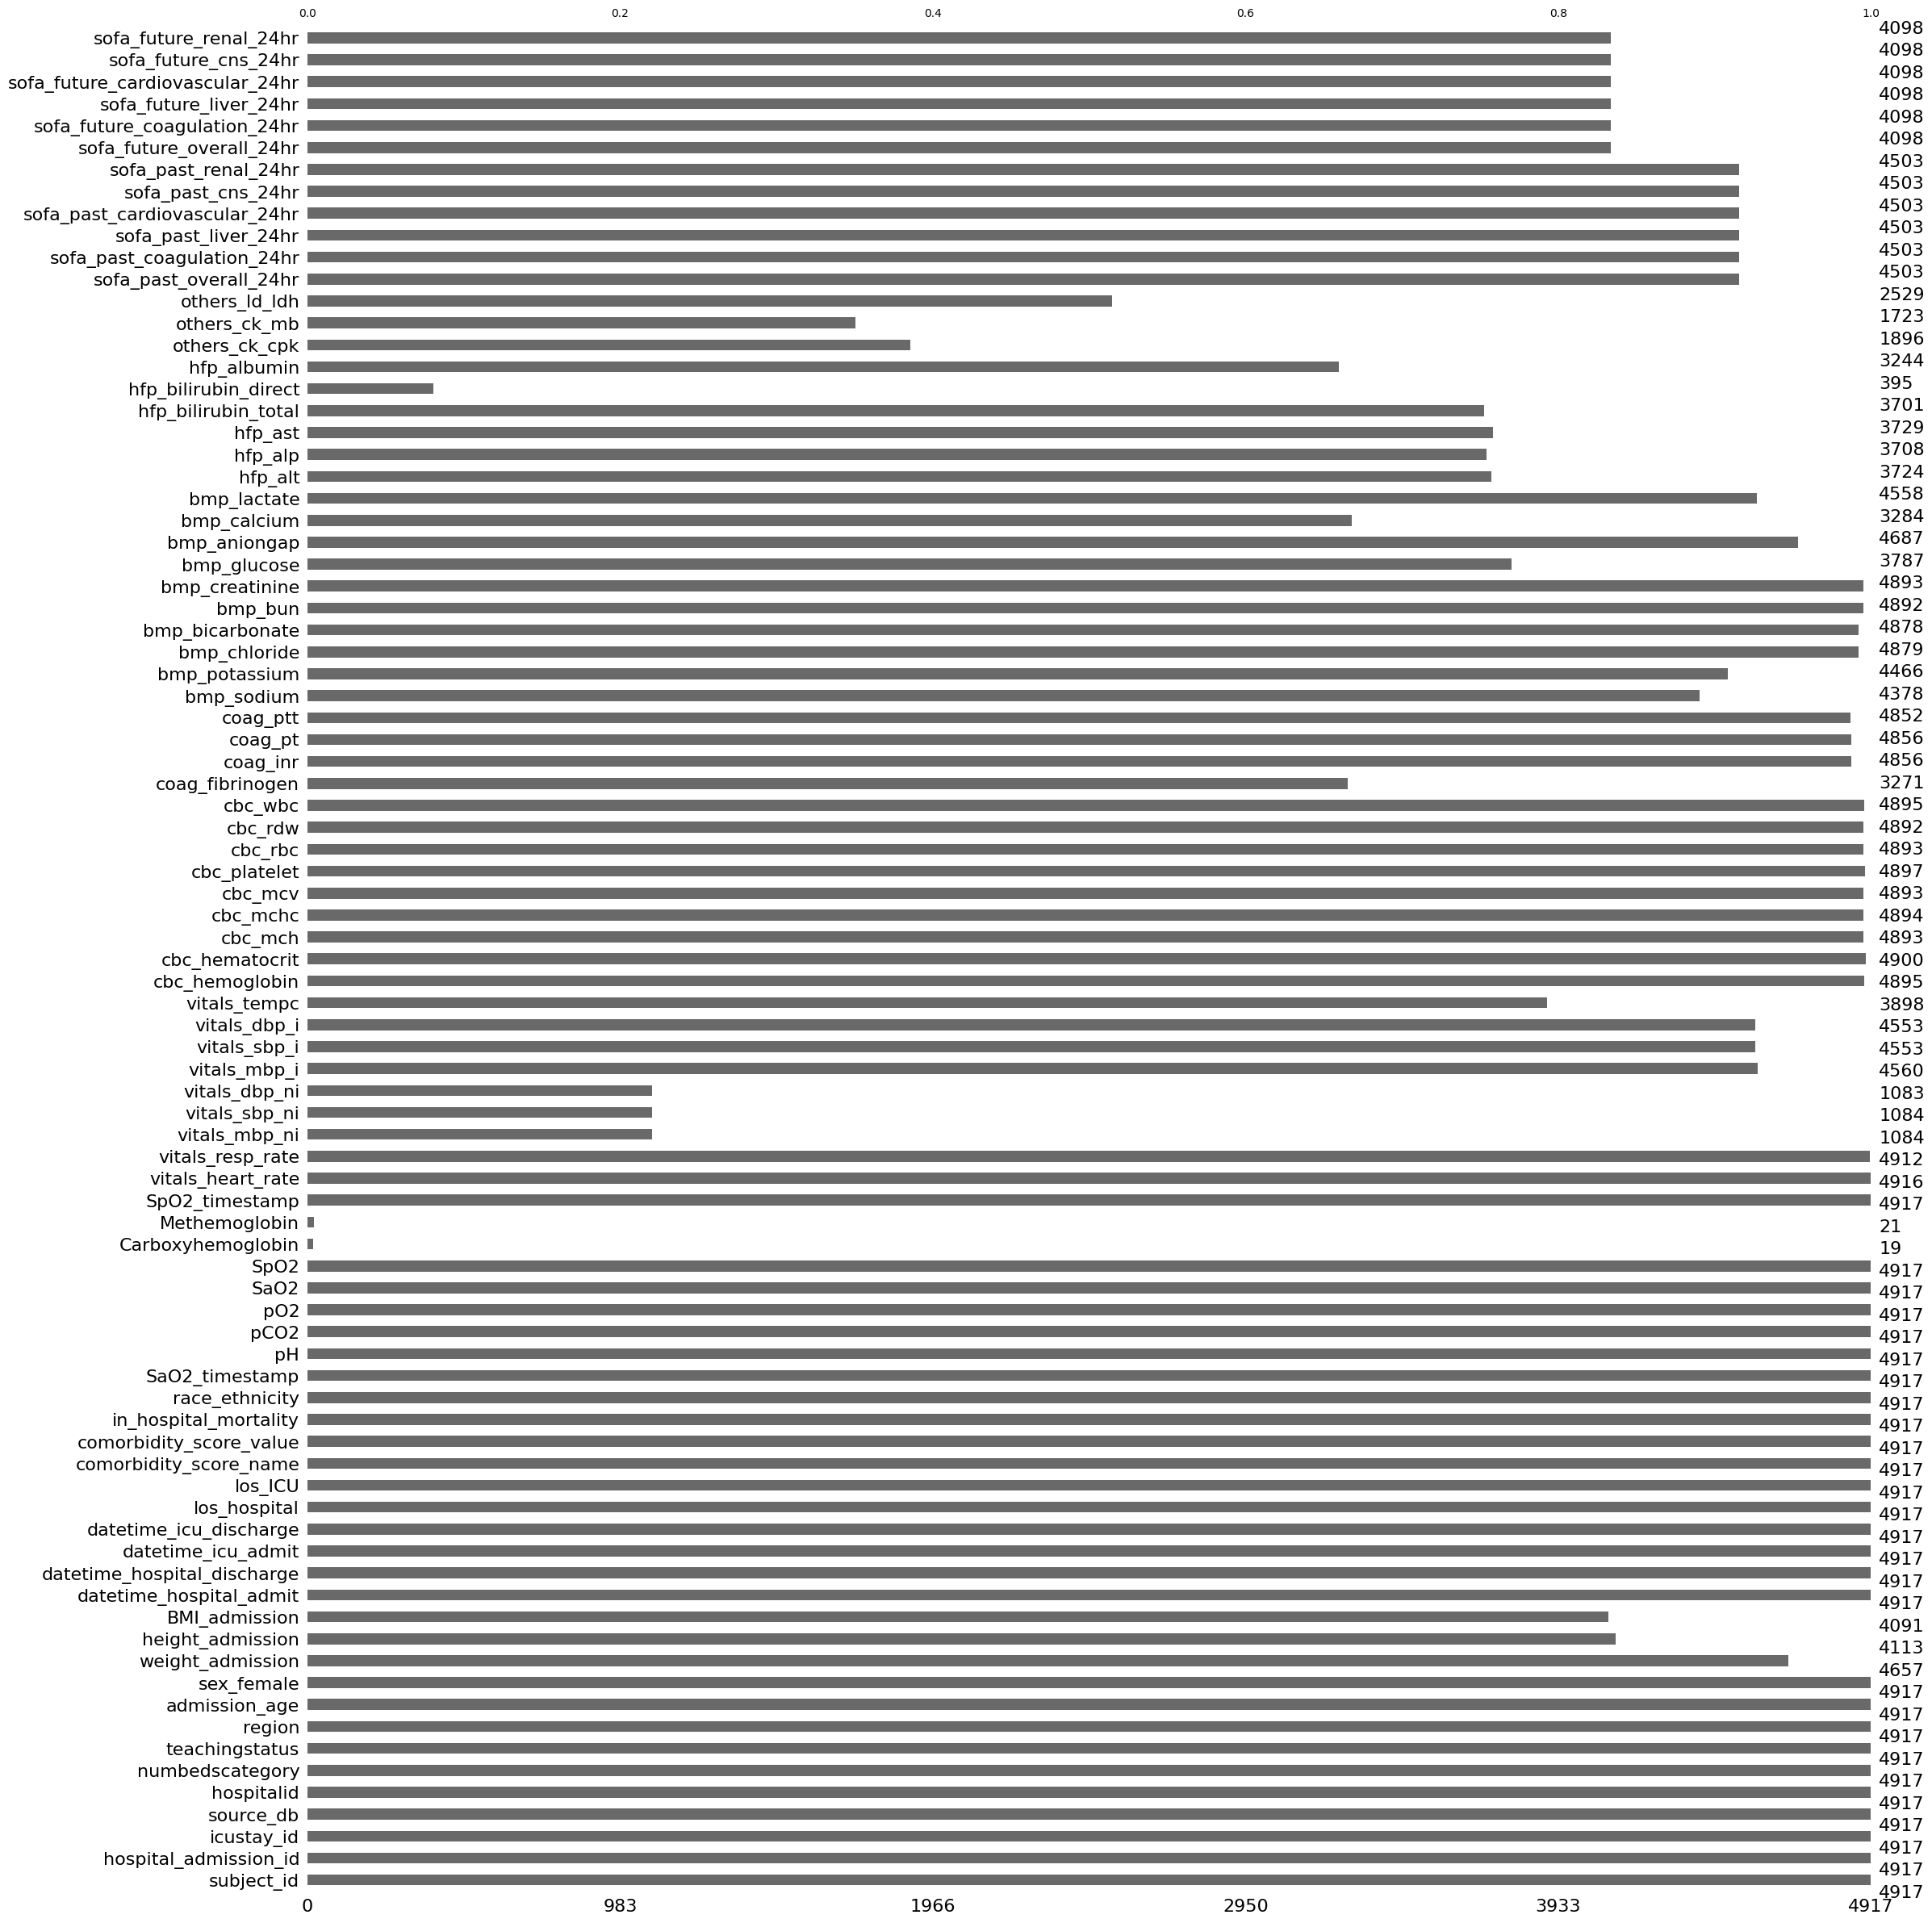

In [179]:
# Plot Missingness Bar Chart
mdf = mimic_iv_merged[[column for column in mimic_iv_merged.columns if not column.startswith('delta_')]]
msno.bar(mdf)

In [180]:
column_names = mdf.columns.tolist()

print(column_names)

['subject_id', 'hospital_admission_id', 'icustay_id', 'source_db', 'hospitalid', 'numbedscategory', 'teachingstatus', 'region', 'admission_age', 'sex_female', 'weight_admission', 'height_admission', 'BMI_admission', 'datetime_hospital_admit', 'datetime_hospital_discharge', 'datetime_icu_admit', 'datetime_icu_discharge', 'los_hospital', 'los_ICU', 'comorbidity_score_name', 'comorbidity_score_value', 'in_hospital_mortality', 'race_ethnicity', 'SaO2_timestamp', 'pH', 'pCO2', 'pO2', 'SaO2', 'SpO2', 'Carboxyhemoglobin', 'Methemoglobin', 'SpO2_timestamp', 'vitals_heart_rate', 'vitals_resp_rate', 'vitals_mbp_ni', 'vitals_sbp_ni', 'vitals_dbp_ni', 'vitals_mbp_i', 'vitals_sbp_i', 'vitals_dbp_i', 'vitals_tempc', 'cbc_hemoglobin', 'cbc_hematocrit', 'cbc_mch', 'cbc_mchc', 'cbc_mcv', 'cbc_platelet', 'cbc_rbc', 'cbc_rdw', 'cbc_wbc', 'coag_fibrinogen', 'coag_inr', 'coag_pt', 'coag_ptt', 'bmp_sodium', 'bmp_potassium', 'bmp_chloride', 'bmp_bicarbonate', 'bmp_bun', 'bmp_creatinine', 'bmp_glucose', 'bmp_

In [181]:
with pd.option_context('display.max_columns', None, 'display.max_rows',3):
  display(mimic_iii_merged.head(2))

,subject_id,hospital_admission_id,icustay_id,source_db,hospitalid,numbedscategory,teachingstatus,region,admission_age,sex_female,weight_admission,height_admission,BMI_admission,datetime_hospital_admit,datetime_hospital_discharge,datetime_icu_admit,datetime_icu_discharge,los_hospital,los_ICU,comorbidity_score_name,comorbidity_score_value,in_hospital_mortality,race_ethnicity,SaO2_timestamp,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_timestamp,delta_SpO2,delta_vitals_heart_rate,vitals_heart_rate,delta_vitals_resp_rate,vitals_resp_rate,delta_vitals_mbp_ni,vitals_mbp_ni,delta_vitals_sbp_ni,vitals_sbp_ni,delta_vitals_dbp_ni,vitals_dbp_ni,delta_vitals_mbp_i,vitals_mbp_i,delta_vitals_sbp_i,vitals_sbp_i,delta_vitals_dbp_i,vitals_dbp_i,delta_vitals_tempc,vitals_tempc,delta_cbc_hemoglobin,cbc_hemoglobin,delta_cbc_hematocrit,cbc_hematocrit,delta_cbc_mch,cbc_mch,delta_cbc_mchc,cbc_mchc,delta_cbc_mcv,cbc_mcv,delta_cbc_platelet,cbc_platelet,delta_cbc_rbc,cbc_rbc,delta_cbc_rdw,cbc_rdw,delta_cbc_wbc,cbc_wbc,delta_coag_fibrinogen,coag_fibrinogen,delta_coag_inr,coag_inr,delta_coag_pt,coag_pt,delta_coag_ptt,coag_ptt,delta_bmp_sodium,bmp_sodium,delta_bmp_potassium,bmp_potassium,delta_bmp_chloride,bmp_chloride,delta_bmp_bicarbonate,bmp_bicarbonate,delta_bmp_bun,bmp_bun,delta_bmp_creatinine,bmp_creatinine,delta_bmp_glucose,bmp_glucose,delta_bmp_aniongap,bmp_aniongap,delta_bmp_calcium,bmp_calcium,delta_bmp_lactate,bmp_lactate,delta_hfp_alt,hfp_alt,delta_hfp_alp,hfp_alp,delta_hfp_ast,hfp_ast,delta_hfp_bilirubin_total,hfp_bilirubin_total,delta_hfp_bilirubin_direct,hfp_bilirubin_direct,delta_hfp_albumin,hfp_albumin,delta_others_ck_cpk,others_ck_cpk,delta_others_ck_mb,others_ck_mb,delta_others_ld_ldh,others_ld_ldh,delta_sofa_past_overall_24hr,sofa_past_overall_24hr,delta_sofa_past_coagulation_24hr,sofa_past_coagulation_24hr,delta_sofa_past_liver_24hr,sofa_past_liver_24hr,delta_sofa_past_cardiovascular_24hr,sofa_past_cardiovascular_24hr,delta_sofa_past_cns_24hr,sofa_past_cns_24hr,delta_sofa_past_renal_24hr,sofa_past_renal_24hr,delta_sofa_future_overall_24hr,sofa_future_overall_24hr,delta_sofa_future_coagulation_24hr,sofa_future_coagulation_24hr,delta_sofa_future_liver_24hr,sofa_future_liver_24hr,delta_sofa_future_cardiovascular_24hr,sofa_future_cardiovascular_24hr,delta_sofa_future_cns_24hr,sofa_future_cns_24hr,delta_sofa_future_renal_24hr,sofa_future_renal_24hr
0,73695,108174,226403,mimic_iii,9999,>= 500,True,Northeast,44,1,92.000000000,167.640000000,32.736520937,2193-07-23 13:11:00,2193-09-22 09:10:00,2193-07-23 13:11:47,2193-09-22 13:42:25,61,61,Elixhauser,5,1,Black,2193-08-30 09:06:00+00:00,7.47,40.0,134.0,98.0,80.0,None,None,2193-08-30 09:03:00+00:00,-3.0,-6,109.0,-6,17.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,-6,69.0,-6,88.0,-6,60.0,-66,36.000000,<NA>,NaN,<NA>,NaN,-344,30.3,-344,33.2,-344,91.0,-344,91.0,-344,2.79,-344,21.8,-344,21.8,-1771,408.0,-6,1.5,-6,16.8,-6,62.0,-1066,133.0,-1066,3.6,-1066,92.0,<NA>,NaN,-6,17.0,<NA>,NaN,-1066,121.0,-6,19.0,0,1.0,0,3.3,-344,163.0,-344,322.0,-344,67.0,-344,2.1,<NA>,NaN,-344,3.0,-4686,397.0,<NA>,NaN,-344,831.0,-66,13,-66,2,-66,2,-66,1,-66,4,-66,4,1554,13,1554,2,1554,2,1554,1,1554,4,1554,4
1,78518,144855,237522,mimic_iii,9999,>= 500,True,Northeast,80,1,90.000000000,157.480000000,36.290395161,2175-08-14 16:58:00,2175-09-22 16:13:00,2175-08-14 16:59:37,2175-09-22 18:54:10,39,39,Elixhauser,5,0,White,2175-09-05 02:00:00+00:00,7.46,36.0,122.0,99.0,97.0,None,None,2175-09-05 02:00:00+00:00,0.0,0,72.0,0,18.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,0,51.0,0,72.0,0,41.0,-120,36.888889,<NA>,NaN,<NA>,NaN,-15,32.2,-15,33.6,-15,96.0,-15,300.0,-15,2.09,-15,22.5,-15,29.0,-9145,603.0,-15,1.2,-15,13.9,-15,28.0,<NA>,NaN,-1134,4.4,<NA>,NaN,<NA>,NaN,-15,34.0,<NA>,NaN,-1134,112.0,-15,14.0,0,1.1,-517,1.5,-15,46.0,-15,207.0,-15,116.0,-15,4.4,<NA>,NaN,-15,2.6,<NA>,NaN,<NA>,NaN,-7346,429.0,-60,10,-60,0,-60,0,-60,1,-60,3,-60,3,1500,7,1500,0,1500,0,1500,1,1500,2,1500,1


<Axes: >

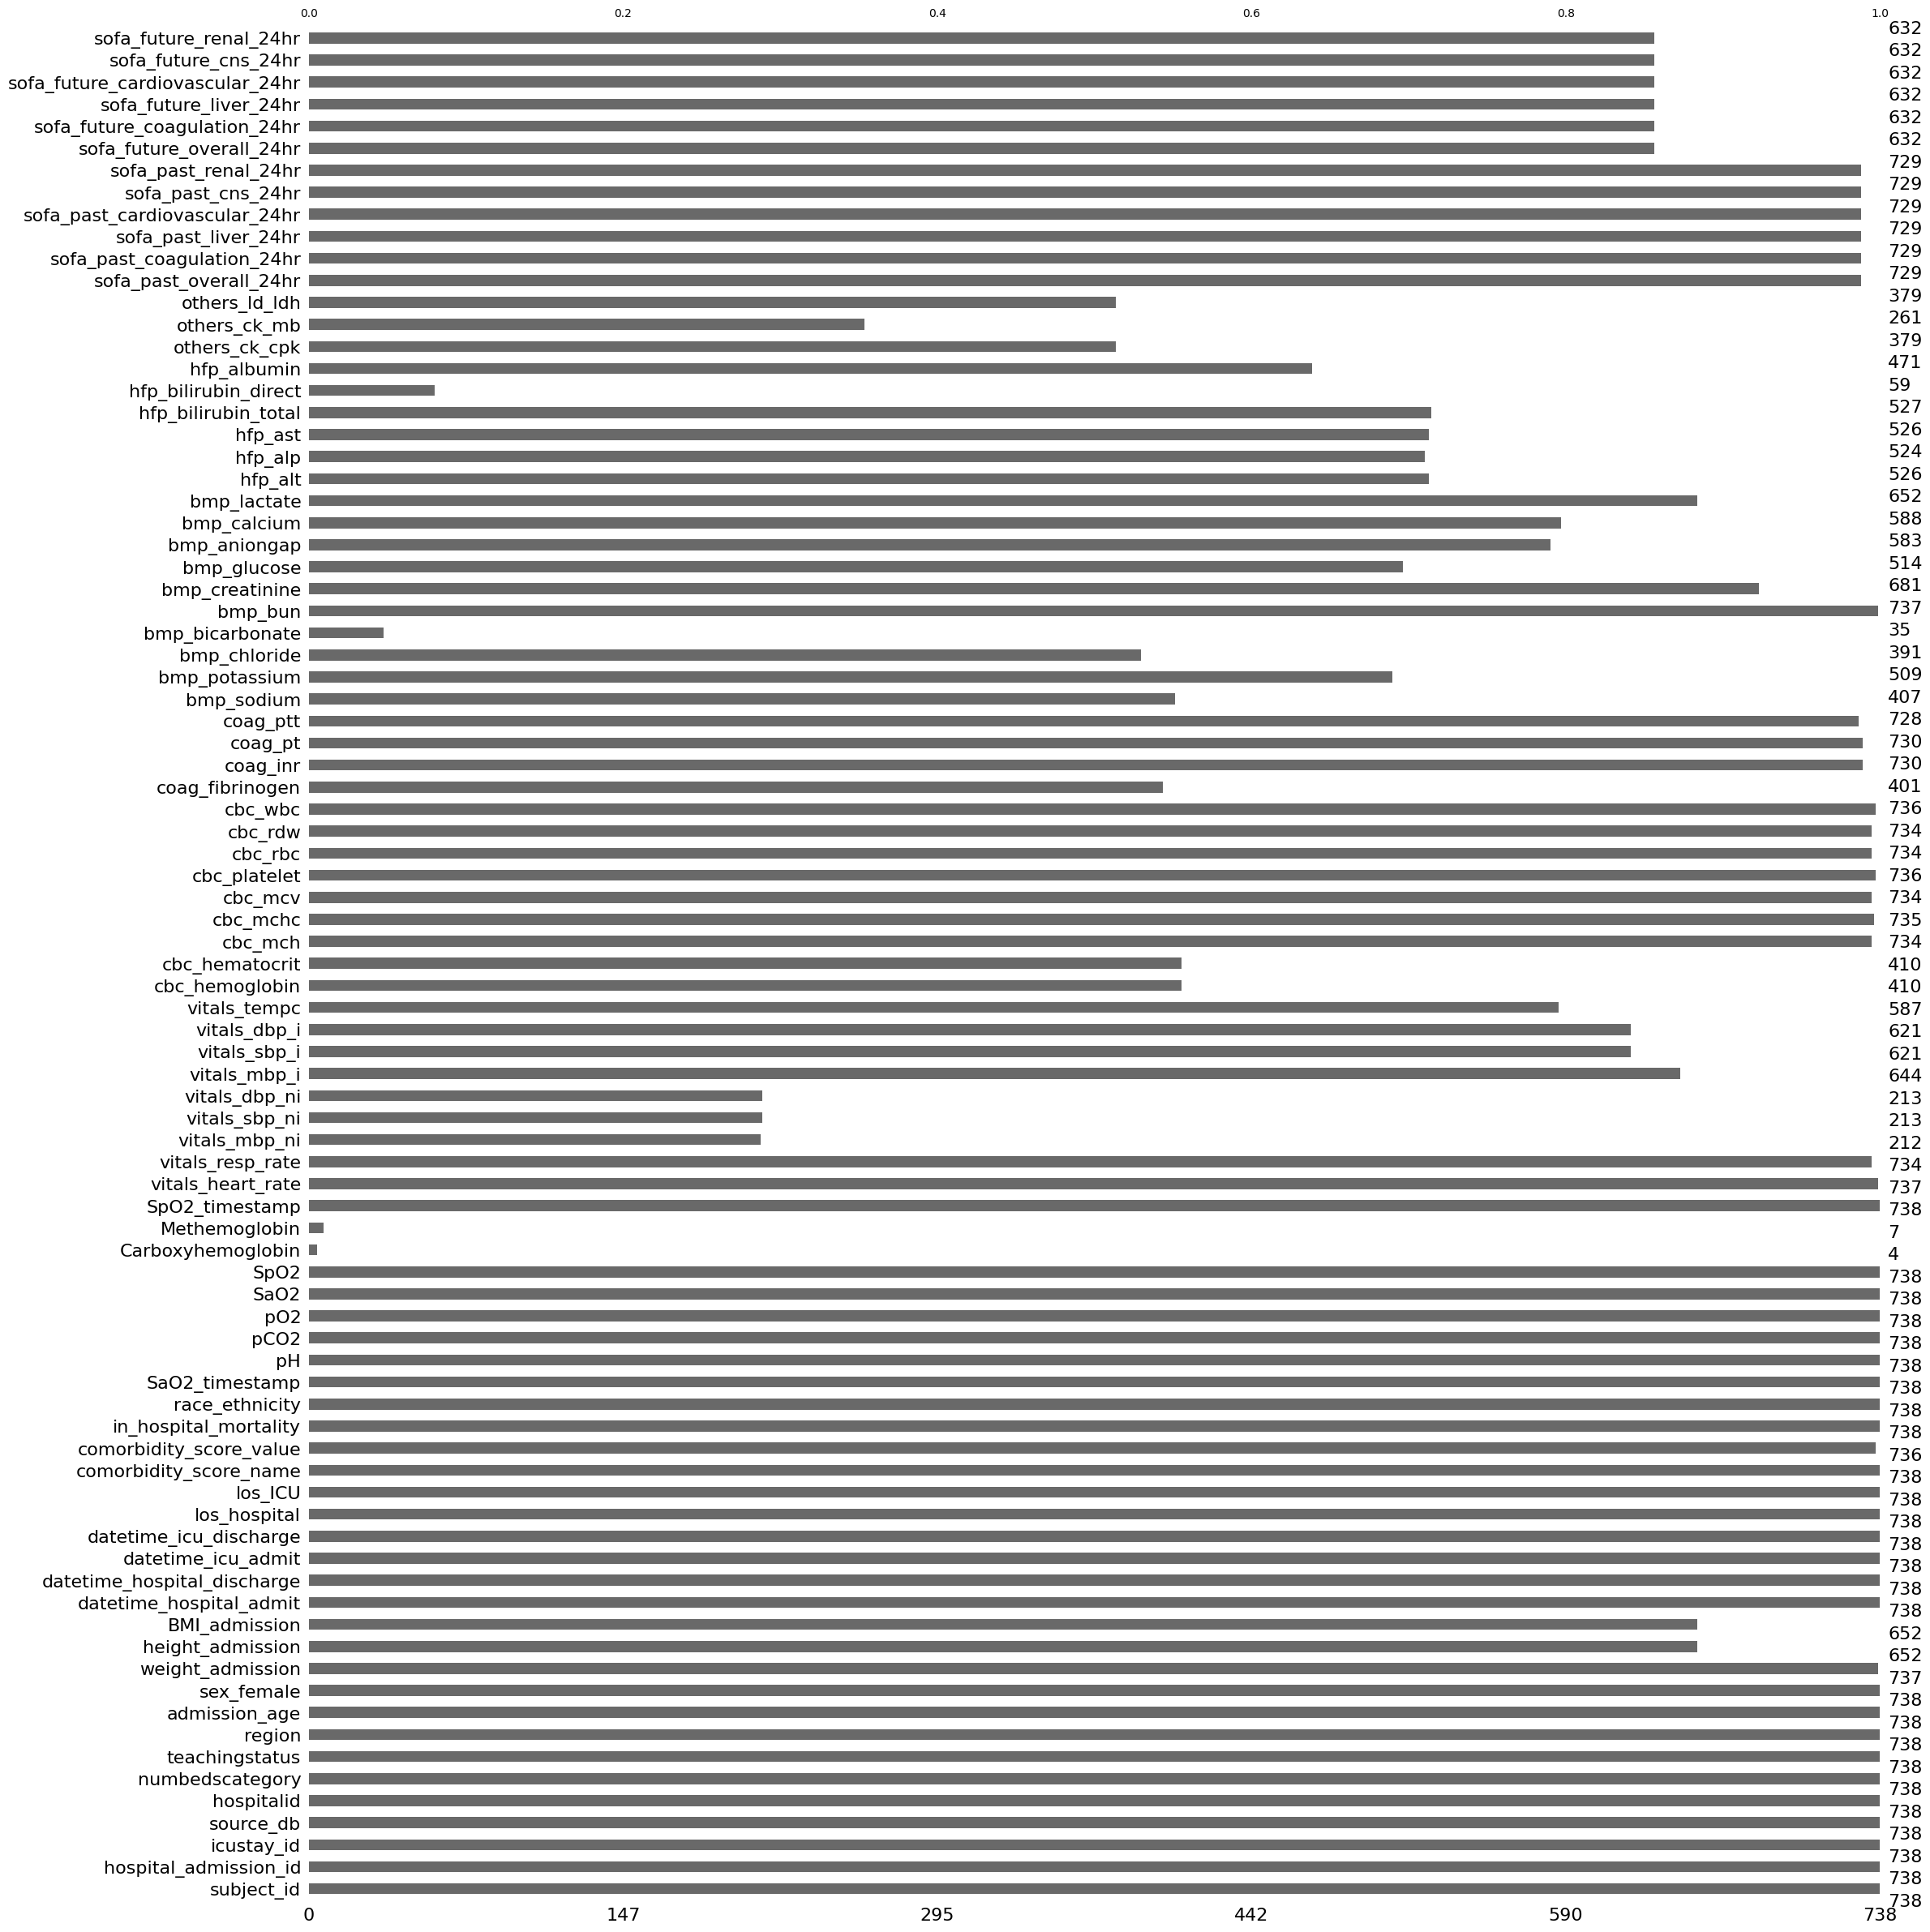

In [182]:
mdf = mimic_iii_merged[[column for column in mimic_iii_merged.columns if not column.startswith('delta_')]]
msno.bar(mdf)

In [183]:
with pd.option_context('display.max_columns', None, 'display.max_rows',3):
  display(eicu_merged.head(2))

,subject_id,hospital_admission_id,icustay_id,source_db,hospitalid,numbedscategory,teachingstatus,region,admission_age,sex_female,weight_admission,height_admission,BMI_admission,datetime_hospital_admit,datetime_hospital_discharge,datetime_icu_admit,datetime_icu_discharge,los_hospital,los_ICU,comorbidity_score_name,comorbidity_score_value,in_hospital_mortality,race_ethnicity,SaO2_timestamp,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_timestamp,delta_SpO2,delta_vitals_heart_rate,vitals_heart_rate,delta_vitals_resp_rate,vitals_resp_rate,delta_vitals_mbp_ni,vitals_mbp_ni,delta_vitals_sbp_ni,vitals_sbp_ni,delta_vitals_dbp_ni,vitals_dbp_ni,delta_vitals_mbp_i,vitals_mbp_i,delta_vitals_sbp_i,vitals_sbp_i,delta_vitals_dbp_i,vitals_dbp_i,delta_vitals_tempc,vitals_tempc,delta_cbc_hemoglobin,cbc_hemoglobin,delta_cbc_hematocrit,cbc_hematocrit,delta_cbc_mch,cbc_mch,delta_cbc_mchc,cbc_mchc,delta_cbc_mcv,cbc_mcv,delta_cbc_platelet,cbc_platelet,delta_cbc_rbc,cbc_rbc,delta_cbc_rdw,cbc_rdw,delta_cbc_wbc,cbc_wbc,delta_coag_fibrinogen,coag_fibrinogen,delta_coag_inr,coag_inr,delta_coag_pt,coag_pt,delta_coag_ptt,coag_ptt,delta_bmp_sodium,bmp_sodium,delta_bmp_potassium,bmp_potassium,delta_bmp_chloride,bmp_chloride,delta_bmp_bicarbonate,bmp_bicarbonate,delta_bmp_bun,bmp_bun,delta_bmp_creatinine,bmp_creatinine,delta_bmp_glucose,bmp_glucose,delta_bmp_aniongap,bmp_aniongap,delta_bmp_calcium,bmp_calcium,delta_bmp_lactate,bmp_lactate,delta_hfp_alt,hfp_alt,delta_hfp_alp,hfp_alp,delta_hfp_ast,hfp_ast,delta_hfp_bilirubin_total,hfp_bilirubin_total,delta_hfp_bilirubin_direct,hfp_bilirubin_direct,delta_hfp_albumin,hfp_albumin,delta_others_ck_cpk,others_ck_cpk,delta_others_ck_mb,others_ck_mb,delta_others_ld_ldh,others_ld_ldh,delta_sofa_past_overall_24hr,sofa_past_overall_24hr,delta_sofa_past_coagulation_24hr,sofa_past_coagulation_24hr,delta_sofa_past_liver_24hr,sofa_past_liver_24hr,delta_sofa_past_cardiovascular_24hr,sofa_past_cardiovascular_24hr,delta_sofa_past_cns_24hr,sofa_past_cns_24hr,delta_sofa_past_renal_24hr,sofa_past_renal_24hr,delta_sofa_future_overall_24hr,sofa_future_overall_24hr,delta_sofa_future_coagulation_24hr,sofa_future_coagulation_24hr,delta_sofa_future_liver_24hr,sofa_future_liver_24hr,delta_sofa_future_cardiovascular_24hr,sofa_future_cardiovascular_24hr,delta_sofa_future_cns_24hr,sofa_future_cns_24hr,delta_sofa_future_renal_24hr,sofa_future_renal_24hr
0,017-101927,1312508,1683112,eicu,256,100 - 249,False,Midwest,90,1,39.7,147.3,18.297216,2013-12-21 09:15:00,2014-01-10 08:33:00,2014-01-01,2014-01-05 23:50:00,19.970833,5.000000,Charlson,7,0,White,2014-01-01 04:35:00,7.48,48.0,167.0,100.0,100,NaN,NaN,2014-01-01 04:35:00,0,-40,104.0,<NA>,NaN,-40,64.0,-40,96.0,-40,48.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,-173,36.6,-670,9.4,-670,30.3,-670,30.3,-670,31.0,-670,97.7,-670,242.0,-670,3.10,-670,13.3,-670,13.39,<NA>,NaN,-670,1.1,-670,13.5,-670,45.5,-670,142.0,-670,3.4,-670,96.0,<NA>,NaN,-670,42.0,-670,0.96,-252,97.0,<NA>,NaN,-670,8.4,<NA>,NaN,-670,23.0,-670,67.0,-670,19.0,-670,0.22,-670,0.08,-670,2.1,<NA>,NaN,<NA>,NaN,<NA>,NaN,-95,2,-95,0,-95,0,-95,1,-95,1,-95,0,1525,4,1525,0,1525,0,1525,1,1525,0,1525,3
1,017-101927,1297391,1665938,eicu,256,100 - 249,False,Midwest,90,1,46.5,147.0,21.518812,2013-12-31 22:06:00,2014-01-07 17:51:00,2014-01-01,2014-01-07 14:15:00,6.822917,6.583333,Charlson,7,1,White,2014-01-02 03:22:00,7.39,42.0,382.0,100.0,100,NaN,NaN,2014-01-02 03:20:00,-2,-31,85.0,<NA>,NaN,-31,69.0,-31,106.0,-31,52.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,-31,37.0,-1366,9.1,-1366,28.8,-1366,30.2,-1366,31.6,-1366,95.7,-1366,245.0,-1366,3.01,-1366,15.1,-1366,8.35,<NA>,NaN,-1951,0.9,-1951,12.3,-1951,34.0,-1366,127.0,-1366,4.2,-1366,94.0,-1366,32.0,-1366,28.0,-1366,1.37,-1366,106.0,-1366,5.0,-1366,6.6,<NA>,NaN,-1949,24.0,-1949,82.0,-1949,30.0,-1949,0.21,-1949,0.06,-1949,1.8,-764,44.0,<NA>,NaN,<NA>,NaN,-82,3,-82,0,-82,0,-82,1,-82,1,-82,1,1538,6,1538,0,1538,0,1538,1,1538,2,1538,3


<Axes: >

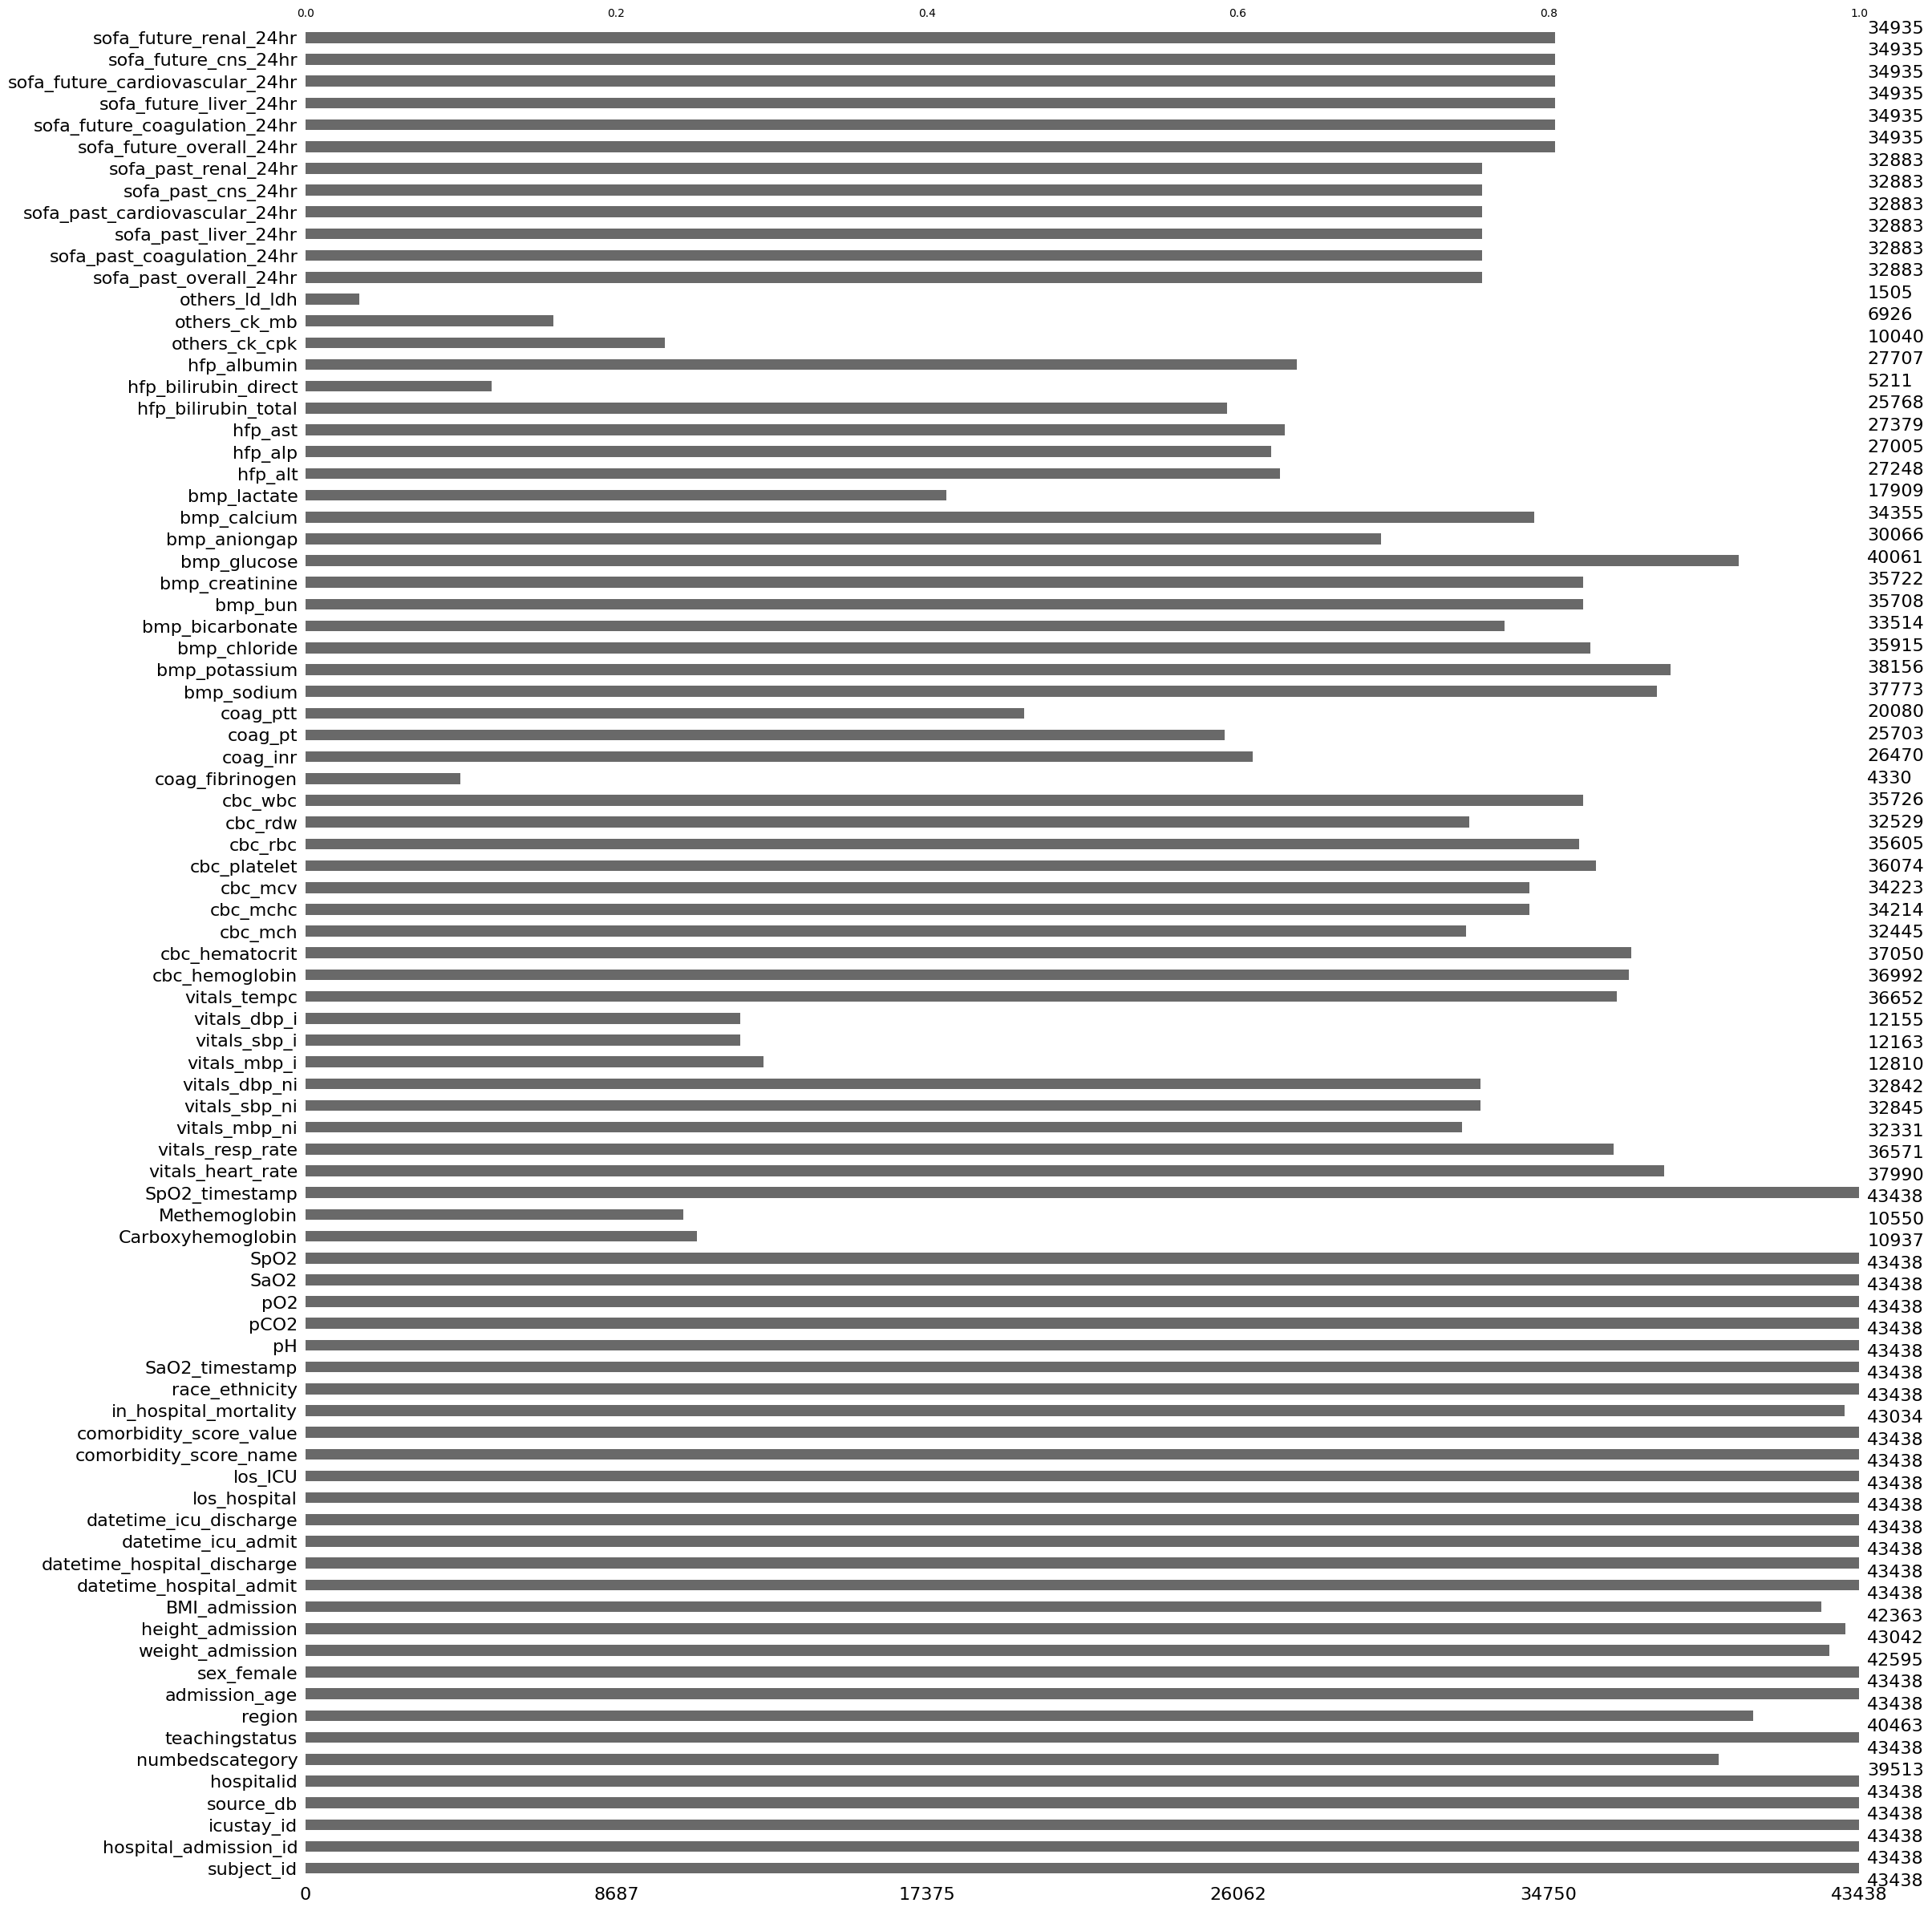

In [184]:
mdf = eicu_merged[[column for column in eicu_merged.columns if not column.startswith('delta_')]]
msno.bar(mdf)

In [185]:
# check all the columns are harmonized
print((mimic_iii_merged.columns == mimic_iv_merged.columns).all())
print((eicu_merged.columns == mimic_iv_merged.columns).all())

True
True


##merge vertically

In [186]:
final_df = pd.concat([mimic_iii_merged, mimic_iv_merged, eicu_merged], ignore_index=True)

In [187]:
with pd.option_context('display.max_columns', None, 'display.max_rows',3):
  display(final_df.head(2))

,subject_id,hospital_admission_id,icustay_id,source_db,hospitalid,numbedscategory,teachingstatus,region,admission_age,sex_female,weight_admission,height_admission,BMI_admission,datetime_hospital_admit,datetime_hospital_discharge,datetime_icu_admit,datetime_icu_discharge,los_hospital,los_ICU,comorbidity_score_name,comorbidity_score_value,in_hospital_mortality,race_ethnicity,SaO2_timestamp,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_timestamp,delta_SpO2,delta_vitals_heart_rate,vitals_heart_rate,delta_vitals_resp_rate,vitals_resp_rate,delta_vitals_mbp_ni,vitals_mbp_ni,delta_vitals_sbp_ni,vitals_sbp_ni,delta_vitals_dbp_ni,vitals_dbp_ni,delta_vitals_mbp_i,vitals_mbp_i,delta_vitals_sbp_i,vitals_sbp_i,delta_vitals_dbp_i,vitals_dbp_i,delta_vitals_tempc,vitals_tempc,delta_cbc_hemoglobin,cbc_hemoglobin,delta_cbc_hematocrit,cbc_hematocrit,delta_cbc_mch,cbc_mch,delta_cbc_mchc,cbc_mchc,delta_cbc_mcv,cbc_mcv,delta_cbc_platelet,cbc_platelet,delta_cbc_rbc,cbc_rbc,delta_cbc_rdw,cbc_rdw,delta_cbc_wbc,cbc_wbc,delta_coag_fibrinogen,coag_fibrinogen,delta_coag_inr,coag_inr,delta_coag_pt,coag_pt,delta_coag_ptt,coag_ptt,delta_bmp_sodium,bmp_sodium,delta_bmp_potassium,bmp_potassium,delta_bmp_chloride,bmp_chloride,delta_bmp_bicarbonate,bmp_bicarbonate,delta_bmp_bun,bmp_bun,delta_bmp_creatinine,bmp_creatinine,delta_bmp_glucose,bmp_glucose,delta_bmp_aniongap,bmp_aniongap,delta_bmp_calcium,bmp_calcium,delta_bmp_lactate,bmp_lactate,delta_hfp_alt,hfp_alt,delta_hfp_alp,hfp_alp,delta_hfp_ast,hfp_ast,delta_hfp_bilirubin_total,hfp_bilirubin_total,delta_hfp_bilirubin_direct,hfp_bilirubin_direct,delta_hfp_albumin,hfp_albumin,delta_others_ck_cpk,others_ck_cpk,delta_others_ck_mb,others_ck_mb,delta_others_ld_ldh,others_ld_ldh,delta_sofa_past_overall_24hr,sofa_past_overall_24hr,delta_sofa_past_coagulation_24hr,sofa_past_coagulation_24hr,delta_sofa_past_liver_24hr,sofa_past_liver_24hr,delta_sofa_past_cardiovascular_24hr,sofa_past_cardiovascular_24hr,delta_sofa_past_cns_24hr,sofa_past_cns_24hr,delta_sofa_past_renal_24hr,sofa_past_renal_24hr,delta_sofa_future_overall_24hr,sofa_future_overall_24hr,delta_sofa_future_coagulation_24hr,sofa_future_coagulation_24hr,delta_sofa_future_liver_24hr,sofa_future_liver_24hr,delta_sofa_future_cardiovascular_24hr,sofa_future_cardiovascular_24hr,delta_sofa_future_cns_24hr,sofa_future_cns_24hr,delta_sofa_future_renal_24hr,sofa_future_renal_24hr
0,73695,108174,226403,mimic_iii,9999,>= 500,True,Northeast,44,1,92.000000000,167.640000000,32.736520937,2193-07-23 13:11:00,2193-09-22 09:10:00,2193-07-23 13:11:47,2193-09-22 13:42:25,61.0,61,Elixhauser,5,1,Black,2193-08-30 09:06:00+00:00,7.47,40.0,134.0,98.0,80.0,None,None,2193-08-30 09:03:00+00:00,-3.0,-6,109.0,-6,17.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,-6,69.0,-6,88.0,-6,60.0,-66,36.0,<NA>,NaN,<NA>,NaN,-344,30.3,-344,33.2,-344,91.0,-344,91.0,-344,2.79,-344,21.8,-344,21.8,-1771,408.0,-6,1.5,-6,16.8,-6,62.0,-1066,133.0,-1066,3.6,-1066,92.0,<NA>,NaN,-6,17.0,<NA>,NaN,-1066,121.0,-6,19.0,0,1.0,0,3.3,-344,163.0,-344,322.0,-344,67.0,-344,2.1,<NA>,NaN,-344,3.0,-4686,397.0,<NA>,NaN,-344,831.0,-66,13,-66,2,-66,2,-66,1,-66,4,-66,4,1554,13,1554,2,1554,2,1554,1,1554,4,1554,4
1,78518,144855,237522,mimic_iii,9999,>= 500,True,Northeast,80,1,90.000000000,157.480000000,36.290395161,2175-08-14 16:58:00,2175-09-22 16:13:00,2175-08-14 16:59:37,2175-09-22 18:54:10,39.0,39,Elixhauser,5,0,White,2175-09-05 02:00:00+00:00,7.46,36.0,122.0,99.0,97.0,None,None,2175-09-05 02:00:00+00:00,0.0,0,72.0,0,18.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,0,51.0,0,72.0,0,41.0,-120,36.888889,<NA>,NaN,<NA>,NaN,-15,32.2,-15,33.6,-15,96.0,-15,300.0,-15,2.09,-15,22.5,-15,29.0,-9145,603.0,-15,1.2,-15,13.9,-15,28.0,<NA>,NaN,-1134,4.4,<NA>,NaN,<NA>,NaN,-15,34.0,<NA>,NaN,-1134,112.0,-15,14.0,0,1.1,-517,1.5,-15,46.0,-15,207.0,-15,116.0,-15,4.4,<NA>,NaN,-15,2.6,<NA>,NaN,<NA>,NaN,-7346,429.0,-60,10,-60,0,-60,0,-60,1,-60,3,-60,3,1500,7,1500,0,1500,0,1500,1,1500,2,1500,1


In [188]:
def rename_columns(dataframe, column_names_old, column_names_new):
    column_mapping = dict(zip(column_names_old, column_names_new))
    dataframe.rename(columns=column_mapping, inplace=True)

# Your first list here
column_names_old = [
    'subject_id', 'hospital_admission_id', 'icustay_id', 'source_db', 'hospitalid', 'numbedscategory',
    'teachingstatus', 'region', 'admission_age', 'sex_female', 'weight_admission', 'height_admission',
    'BMI_admission', 'datetime_hospital_admit', 'datetime_hospital_discharge', 'datetime_icu_admit',
    'datetime_icu_discharge', 'los_hospital', 'los_ICU', 'comorbidity_score_name', 'comorbidity_score_value',
    'in_hospital_mortality', 'race_ethnicity', 'SaO2_timestamp', 'pH', 'pCO2', 'pO2', 'SaO2', 'SpO2',
    'Carboxyhemoglobin', 'Methemoglobin', 'SpO2_timestamp', 'vitals_heart_rate', 'vitals_resp_rate',
    'vitals_mbp_ni', 'vitals_sbp_ni', 'vitals_dbp_ni', 'vitals_mbp_i', 'vitals_sbp_i', 'vitals_dbp_i',
    'vitals_tempc', 'cbc_hemoglobin', 'cbc_hematocrit', 'cbc_mch', 'cbc_mchc', 'cbc_mcv', 'cbc_platelet',
    'cbc_rbc', 'cbc_rdw', 'cbc_wbc', 'coag_fibrinogen', 'coag_inr', 'coag_pt', 'coag_ptt', 'bmp_sodium',
    'bmp_potassium', 'bmp_chloride', 'bmp_bicarbonate', 'bmp_bun', 'bmp_creatinine', 'bmp_glucose',
    'bmp_aniongap', 'bmp_calcium', 'bmp_lactate', 'hfp_alt', 'hfp_alp', 'hfp_ast', 'hfp_bilirubin_total',
    'hfp_bilirubin_direct', 'hfp_albumin', 'others_ck_cpk', 'others_ck_mb', 'others_ld_ldh',
    'sofa_past_overall_24hr', 'sofa_past_coagulation_24hr',
    'sofa_past_liver_24hr', 'sofa_past_cardiovascular_24hr', 'sofa_past_cns_24hr', 'sofa_past_renal_24hr',
    'sofa_future_overall_24hr', 'sofa_future_coagulation_24hr', 'sofa_future_liver_24hr',
    'sofa_future_cardiovascular_24hr', 'sofa_future_cns_24hr', 'sofa_future_renal_24hr'
]

# Your second list here
column_names_new = [
    'Subject ID', 'Hospital Admission ID', 'ICU Stay ID', 'Source Database', 'Hospital ID', 'Number of Beds Category',
    'Teaching Status', 'US Census Region', 'Admission Age', 'Female Sex', 'Admission Weight', 'Admission Height',
    'Admission BMI', 'Datetime of Hospital Admission', 'Datetime of Hospital Discharge', 'Datetime of ICU Admission',
    'Datetime of ICU Discharge', 'LOS Hospital', 'LOS ICU', 'Comorbidity Score Name', 'Comorbidity Score (Charlson/Elixhauser)',
    'In-Hospital Mortality', 'Race-Ethnicity', 'SaO2 Timestamp', 'pH', 'pCO2', 'pO2', 'SaO2', 'SpO2',
    'Carboxyhemoglobin', 'Methemoglobin', 'SpO2 Timestamp', 'Vitals Heart Rate', 'Vitals Resp Rate',
    'Vitals niMBP', 'Vitals niSBP', 'Vitals niDBP', 'Vitals iMBP', 'Vitals iSBP', 'Vitals iDBP',
    'Vitals Temp', 'CBC Hemoglobin', 'CBC Hematocrit', 'CBC MCH', 'CBC MCHC', 'CBC MCV', 'CBC Platelets',
    'CBC RBC', 'CBC RDW', 'CBC WBC', 'Coagulation Fibrinogen', 'Coagulation INR', 'Coagulation PT', 'Coagulation PTT', 'Sodium',
    'Potassium', 'Chloride', 'Bicarbonate', 'Blood Urea Nitrogen', 'Creatinine', 'Glucose',
    'Anion-gap', 'Calcium', 'Lactate', 'Alanine Transaminase', 'Alkaline Phosphatase', 'Aspartate Transaminase', 'Bilirubin Total',
    'Bilirubin Direct', 'Albumin', 'Creatine Kinase', 'Creatine Kinase MB', 'Lactate Dehydrogenase',
    'SOFA Past Overall 24hr', 'SOFA Past Coagulation 24hr',
    'SOFA Past Liver 24hr', 'SOFA Past Cardiovascular 24hr', 'SOFA Past CNS 24hr', 'SOFA Past Renal 24hr',
    'SOFA Future Overall 24hr', 'SOFA Future Coagulation 24hr', 'SOFA Future Liver 24hr',
    'SOFA Future Cardiovascular 24hr', 'SOFA Future CNS 24hr', 'SOFA Future Renal 24hr'
]

# Define columns of interest
columns_retained = [
    'subject_id', 'hospital_admission_id', 'icustay_id', 'source_db', 'hospitalid', 'numbedscategory',
    'teachingstatus', 'region', 'admission_age', 'sex_female', 'weight_admission', 'datetime_hospital_admit',
    'datetime_hospital_discharge', 'datetime_icu_admit', 'datetime_icu_discharge', 'los_hospital', 'los_ICU',
    'comorbidity_score_name', 'comorbidity_score_value', 'in_hospital_mortality', 'race_ethnicity', 'SaO2_timestamp',
    'Carboxyhemoglobin', 'Methemoglobin', 'SpO2_timestamp', 'cbc_hemoglobin', 'coag_fibrinogen', 'coag_inr', 'coag_pt',
    'coag_ptt', 'bmp_sodium', 'bmp_potassium', 'bmp_chloride', 'bmp_bicarbonate', 'bmp_bun', 'bmp_creatinine',
    'bmp_glucose', 'bmp_lactate', 'hfp_alt', 'hfp_alp', 'hfp_ast', 'hfp_bilirubin_total', 'hfp_albumin',
    'others_ck_cpk', 'sofa_past_overall_24hr', 'sofa_future_overall_24hr'
]

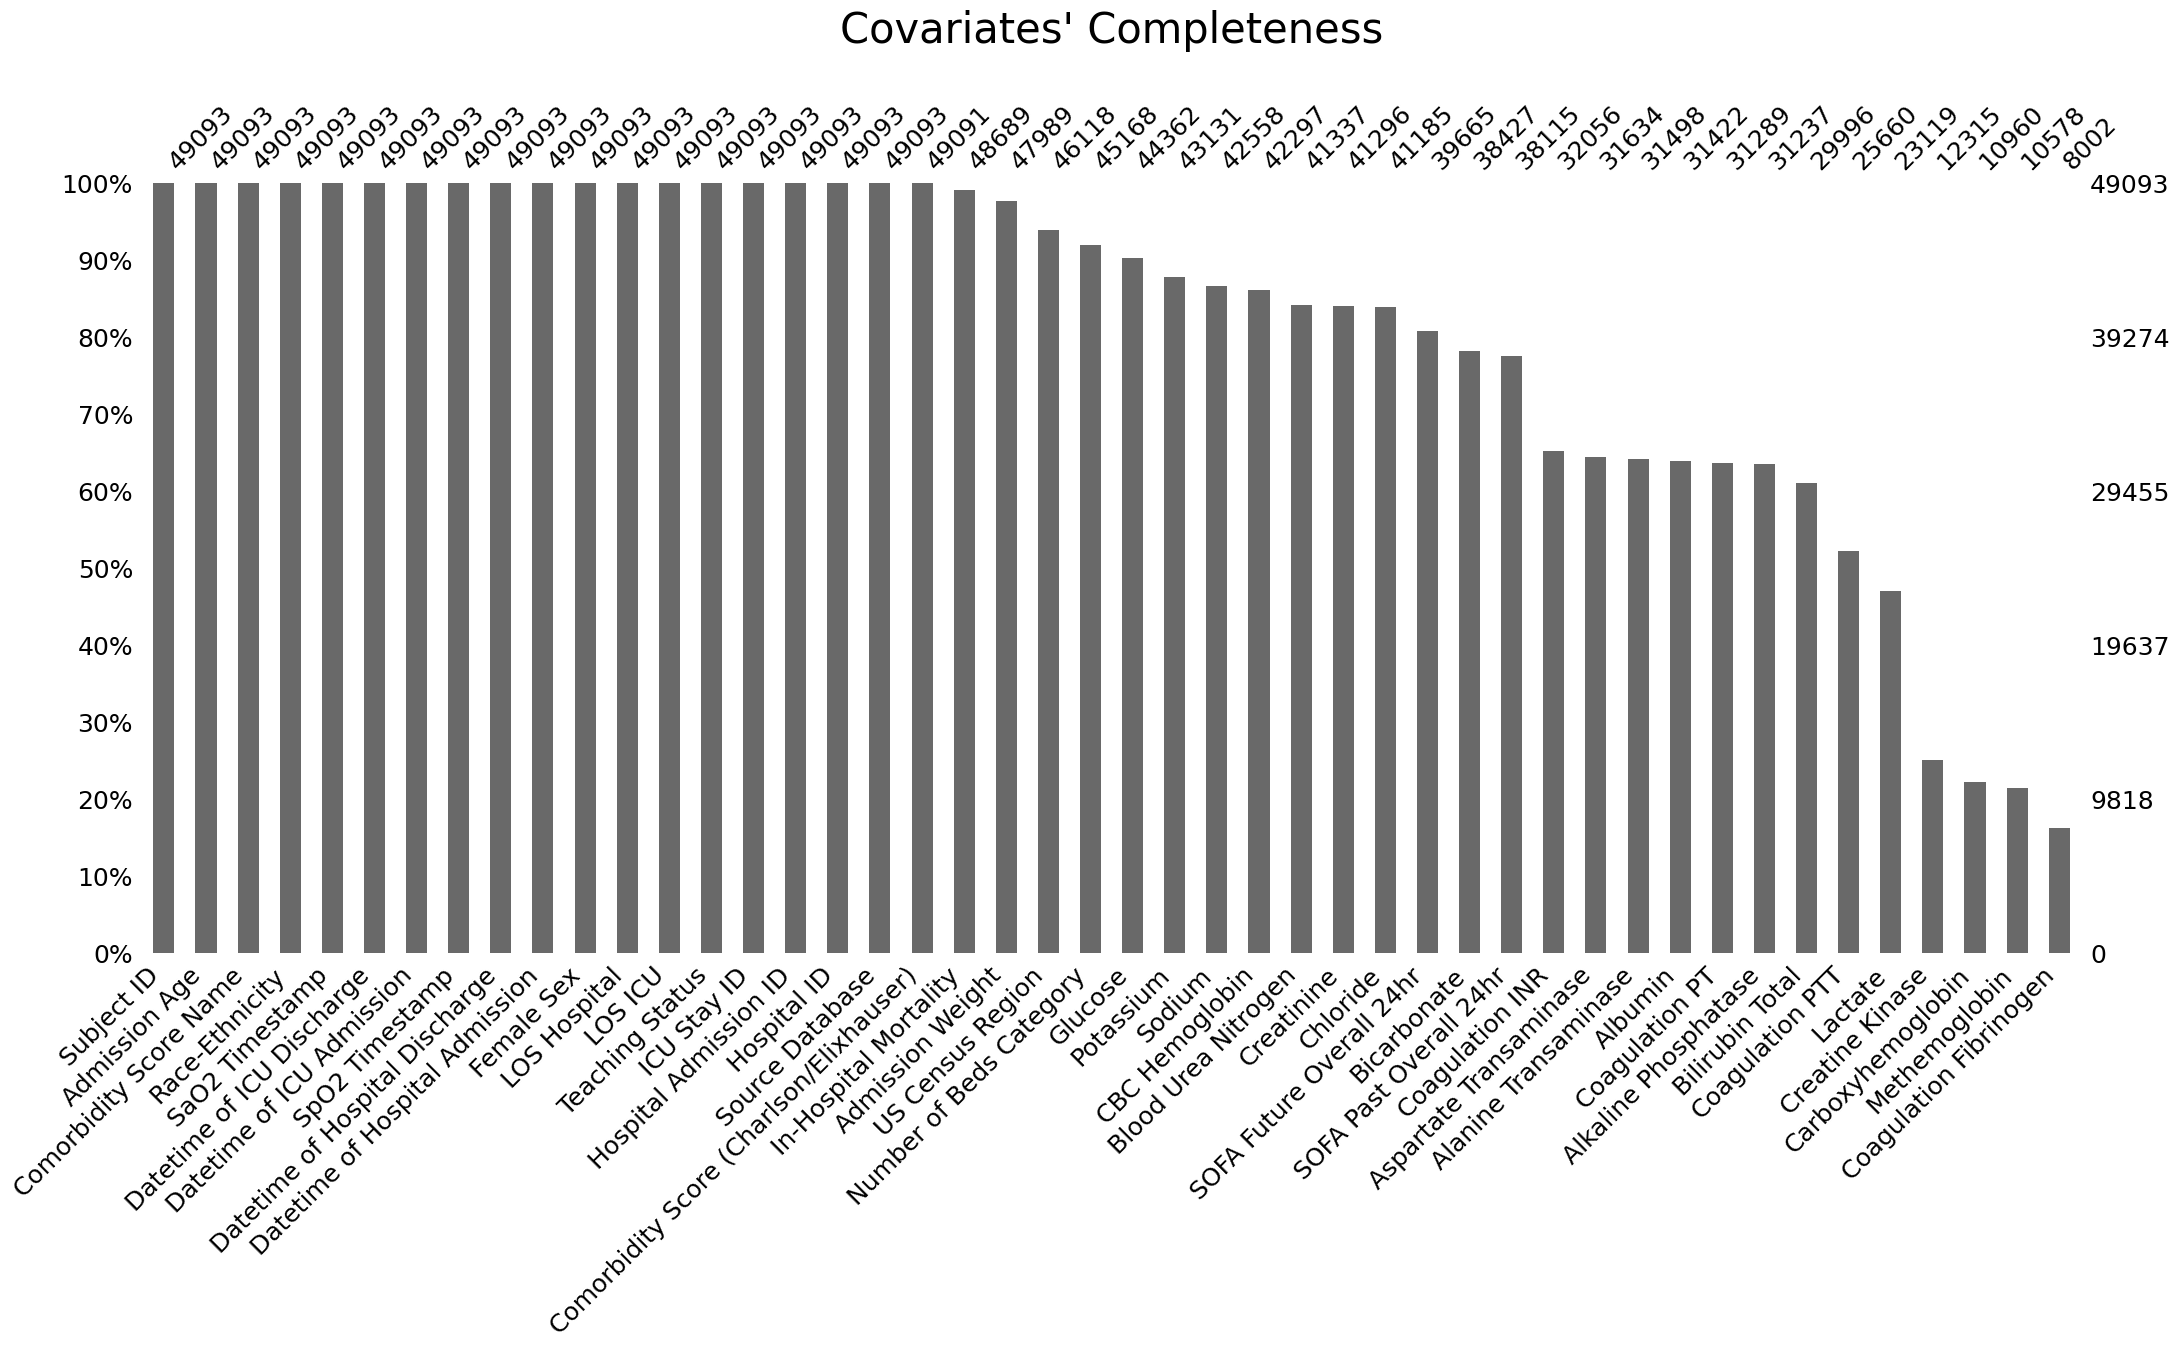

In [189]:
mdf = final_df[[column for column in final_df.columns if not column.startswith('delta_')]]

# Retain only columns of interest
mdf = mdf[columns_retained]

# Call the function to rename the columns
rename_columns(mdf, column_names_old, column_names_new)

# Plot Missingness Bar Chart

mdf_sorted = msno.nullity_sort(mdf, sort='descending') # or sort='ascending'
bar = msno.bar(mdf_sorted, filter='top', sort='descending', fontsize = 18,  label_rotation=45)

#bar.axes[0].tick_params(axis='y', labelsize=30)

# Modify y-axis labels to percentages
plt.yticks(np.arange(0, 1.1, 0.1), [str(int(x * 100)) + '%' for x in np.arange(0, 1.1, 0.1)])
plt.title("Covariates' Completeness\n", fontsize=30)
plt.show()

## final harmonizations / unique ids

In [190]:
# harmonize missingness
final_df = final_df.replace("___", np.nan)

# Replace instances of None with NaN
final_df = final_df.replace("None", np.nan)

# fix subject_id
final_df['subject_id'] = final_df['subject_id'].astype(str)
# final_df['subject_id'] = final_df['subject_id'].str.replace('-', '')

# fix age
final_df['admission_age'] = pd.to_numeric(final_df['admission_age'])

data_types = {
    'subject_id': str,
    'hospital_admission_id': int,
    'icustay_id': int,
    'pH': float,
    'pCO2': float,
    'pO2': float,
    'SaO2': float,
    'SpO2': float,
    'Carboxyhemoglobin': float,
    'Methemoglobin': float,
    'delta_SpO2': float,
    'datetime_hospital_admit': str,
    'datetime_hospital_discharge': str,
    'datetime_icu_admit': str,
    'datetime_icu_discharge': str
}

final_df = final_df.astype(data_types)

# Display the merged DataFrame
display(final_df.head(2))

,subject_id,hospital_admission_id,icustay_id,source_db,hospitalid,numbedscategory,teachingstatus,region,admission_age,sex_female,...,delta_sofa_future_coagulation_24hr,sofa_future_coagulation_24hr,delta_sofa_future_liver_24hr,sofa_future_liver_24hr,delta_sofa_future_cardiovascular_24hr,sofa_future_cardiovascular_24hr,delta_sofa_future_cns_24hr,sofa_future_cns_24hr,delta_sofa_future_renal_24hr,sofa_future_renal_24hr
0,73695,108174,226403,mimic_iii,9999,>= 500,True,Northeast,44.0,1,...,1554,2,1554,2,1554,1,1554,4,1554,4
1,78518,144855,237522,mimic_iii,9999,>= 500,True,Northeast,80.0,1,...,1500,0,1500,0,1500,1,1500,2,1500,1


In [191]:
final_df = final_df.sort_values(by=['source_db', 'subject_id', 'hospital_admission_id', 'icustay_id'])

final_df['unique_subject_id'] = pd.factorize(final_df['source_db'].astype(str) + final_df['subject_id'].astype(str))[0] % 1000000
final_df['unique_hospital_admission_id'] = pd.factorize(final_df['source_db'].astype(str) + final_df['hospital_admission_id'].astype(str))[0] % 1000000
final_df['unique_icustay_id'] = pd.factorize(final_df['source_db'].astype(str) + final_df['icustay_id'].astype(str))[0] % 1000000

# move the unique columns to the front
cols = ['unique_subject_id', 'unique_hospital_admission_id', 'unique_icustay_id'] + [col for col in final_df.columns if col not in ['unique_subject_id', 'unique_hospital_admission_id', 'unique_icustay_id']]
final_df = final_df[cols]


In [192]:
with pd.option_context('display.max_columns',None):
  display(final_df.head(2))

,unique_subject_id,unique_hospital_admission_id,unique_icustay_id,subject_id,hospital_admission_id,icustay_id,source_db,hospitalid,numbedscategory,teachingstatus,region,admission_age,sex_female,weight_admission,height_admission,BMI_admission,datetime_hospital_admit,datetime_hospital_discharge,datetime_icu_admit,datetime_icu_discharge,los_hospital,los_ICU,comorbidity_score_name,comorbidity_score_value,in_hospital_mortality,race_ethnicity,SaO2_timestamp,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_timestamp,delta_SpO2,delta_vitals_heart_rate,vitals_heart_rate,delta_vitals_resp_rate,vitals_resp_rate,delta_vitals_mbp_ni,vitals_mbp_ni,delta_vitals_sbp_ni,vitals_sbp_ni,delta_vitals_dbp_ni,vitals_dbp_ni,delta_vitals_mbp_i,vitals_mbp_i,delta_vitals_sbp_i,vitals_sbp_i,delta_vitals_dbp_i,vitals_dbp_i,delta_vitals_tempc,vitals_tempc,delta_cbc_hemoglobin,cbc_hemoglobin,delta_cbc_hematocrit,cbc_hematocrit,delta_cbc_mch,cbc_mch,delta_cbc_mchc,cbc_mchc,delta_cbc_mcv,cbc_mcv,delta_cbc_platelet,cbc_platelet,delta_cbc_rbc,cbc_rbc,delta_cbc_rdw,cbc_rdw,delta_cbc_wbc,cbc_wbc,delta_coag_fibrinogen,coag_fibrinogen,delta_coag_inr,coag_inr,delta_coag_pt,coag_pt,delta_coag_ptt,coag_ptt,delta_bmp_sodium,bmp_sodium,delta_bmp_potassium,bmp_potassium,delta_bmp_chloride,bmp_chloride,delta_bmp_bicarbonate,bmp_bicarbonate,delta_bmp_bun,bmp_bun,delta_bmp_creatinine,bmp_creatinine,delta_bmp_glucose,bmp_glucose,delta_bmp_aniongap,bmp_aniongap,delta_bmp_calcium,bmp_calcium,delta_bmp_lactate,bmp_lactate,delta_hfp_alt,hfp_alt,delta_hfp_alp,hfp_alp,delta_hfp_ast,hfp_ast,delta_hfp_bilirubin_total,hfp_bilirubin_total,delta_hfp_bilirubin_direct,hfp_bilirubin_direct,delta_hfp_albumin,hfp_albumin,delta_others_ck_cpk,others_ck_cpk,delta_others_ck_mb,others_ck_mb,delta_others_ld_ldh,others_ld_ldh,delta_sofa_past_overall_24hr,sofa_past_overall_24hr,delta_sofa_past_coagulation_24hr,sofa_past_coagulation_24hr,delta_sofa_past_liver_24hr,sofa_past_liver_24hr,delta_sofa_past_cardiovascular_24hr,sofa_past_cardiovascular_24hr,delta_sofa_past_cns_24hr,sofa_past_cns_24hr,delta_sofa_past_renal_24hr,sofa_past_renal_24hr,delta_sofa_future_overall_24hr,sofa_future_overall_24hr,delta_sofa_future_coagulation_24hr,sofa_future_coagulation_24hr,delta_sofa_future_liver_24hr,sofa_future_liver_24hr,delta_sofa_future_cardiovascular_24hr,sofa_future_cardiovascular_24hr,delta_sofa_future_cns_24hr,sofa_future_cns_24hr,delta_sofa_future_renal_24hr,sofa_future_renal_24hr
11610,0,0,0,002-10050,183274,211144,eicu,71,100 - 249,False,Midwest,67.0,1,86.2,160.0,33.671875,2013-12-31 22:53:00,2014-01-07 17:37:00,2014-01-01 00:00:00,2014-01-04 20:19:00,6.780556,3.833333,Charlson,3,0,White,2014-01-01 00:35:00,7.25,55.0,86.0,94.0,97.0,NaN,NaN,2014-01-01 00:34:00,-1.0,-1,83.0,-1,23.0,<NA>,NaN,-1,111.0,-1,60.0,-1,80.0,-1,147.0,-1,58.0,-1,37.4,-51,13.2,-51,39.8,-51,29.2,-51,33.2,-51,88.1,-51,145.0,-51,4.52,-51,13.7,-51,17.3,-51,179.0,-51,1.1,-51,11.6,-51,25.0,<NA>,NaN,-51,3.1,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,-2,133.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1525,5,1525,1,1525,0,1525,1,1525,0,1525,0
26987,1,1,1,002-1007,178462,204935,eicu,71,100 - 249,False,Midwest,83.0,1,NaN,162.6,NaN,2013-12-30 12:04:00,2014-01-02 02:33:00,2014-01-01 00:00:00,2014-01-01 12:03:00,2.603472,0.5,Charlson,9,1,White,2014-01-01 05:14:00,7.31,32.0,116.0,98.0,95.0,NaN,NaN,2014-01-01 05:14:00,0.0,-36,135.0,-36,16.0,<NA>,NaN,-36,99.0,-36,65.0,-36,77.0,<NA>,NaN,<NA>,NaN,-19,36.6,-546,9.4,-546,30.7,-546,25.6,-546,30.6,-546,83.7,-546,314.0,-546,3.67,-546,16.8,-546,7.9,<NA>,NaN,-546,1.2,-546,12.7,-546,31.0,-546,141.0,-546,5.1,-546,108.0,-546,18.0,-546,87.0,-546,4.4,-214,194.0,-546,20.0,-546,8.3,<NA>,NaN,-546,14.0,-546,97.0,-546,11.0,-546,0.3,<NA>,NaN,-546,2.6,<NA>,NaN,<NA>,NaN,<NA>,NaN,-74,3,-74,0,-74,0,-74,0,-74,0,-74,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [193]:
with pd.option_context('display.max_columns',None, 'display.max_rows',None):
  display(final_df.dtypes)

unique_subject_id                          int64
unique_hospital_admission_id               int64
unique_icustay_id                          int64
subject_id                                object
hospital_admission_id                      int64
icustay_id                                 int64
source_db                                 object
hospitalid                                 Int64
numbedscategory                           object
teachingstatus                           boolean
region                                    object
admission_age                            float64
sex_female                                 Int64
weight_admission                          object
height_admission                          object
BMI_admission                             object
datetime_hospital_admit                   object
datetime_hospital_discharge               object
datetime_icu_admit                        object
datetime_icu_discharge                    object
los_hospital        

##final download

In [194]:
len(final_df.groupby(by=['hospital_admission_id', 'source_db',]).first()) == len(final_df)

True

In [195]:
final_df.to_csv('final_df.csv', index=False)
files.download('final_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## big df for validation

In [196]:
mimic_iv_pairs_big = mimic_iv['SpO2_SaO2_pairs'].rename({'stay_id': 'icustay_id'},
                                                          axis = 1)

mimic_iv_pairs_big.head(2)

,subject_id,hadm_id,icustay_id,SaO2_timestamp,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_timestamp,delta_SpO2
17,18106347,24305596,30588857,2110-01-11 16:07:00,7.40,37.0,140.0,98.0,100.0,None,None,2110-01-11 16:00:00,-7.0
18,16284044,23864737,36817845,2110-01-13 14:42:00,7.32,37.0,133.0,98.0,100.0,None,None,2110-01-13 14:14:00,-28.0


In [197]:
mimic_iii_pairs_big = mimic_iii['SpO2_SaO2_pairs'].rename({'SUBJECT_ID': 'subject_id',
                                                           'HADM_ID': 'hadm_id'},
                                                          axis = 1)

mimic_iii_pairs_big.head(2)

,subject_id,hadm_id,icustay_id,SaO2_timestamp,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_timestamp,delta_SpO2
17,84585,182054,245641,2100-08-03 01:28:00,7.37,36.0,43.0,79.0,100.0,None,0,2100-08-03 01:15:00,-13.0
18,84585,182054,245641,2100-08-03 02:11:00,7.38,37.0,51.0,88.0,98.0,None,None,2100-08-03 02:00:00,-11.0


In [198]:
eicu_pairs_big = eicu['SpO2_SaO2_pairs'].rename({'uniquepid': 'subject_id',
                                                 'patientunitstayid': 'icustay_id',
                                                 'labresultoffset': 'SaO2_timestamp',
                                                 'paCO2': 'pCO2',
                                                 'paO2': 'pO2',
                                                 'observationoffset': 'SpO2_timestamp',
                                                 'patienthealthsystemstayid': 'hadm_id'},
                                                axis = 1)

eicu_pairs_big = eicu_pairs_big.drop(['patientunitstayid_vitals',
                                      'patientunitstayid_patient',
                                      'labresultrevisedoffset'],
                                      axis = 1)

eicu_pairs_big['delta_SpO2'] = eicu_pairs_big['SpO2_timestamp'] \
                             - eicu_pairs_big['SaO2_timestamp']

cols = eicu_pairs_big.columns.tolist()
cols.insert(1, cols.pop(cols.index('hadm_id')))
cols.insert(8, cols.pop(cols.index('SpO2')))
eicu_pairs_big = eicu_pairs_big[cols]

eicu_pairs_big['subject_id'] = eicu_pairs_big['subject_id'].str.replace('-', '').astype(int)

eicu_pairs_big.head(2)

,subject_id,hadm_id,icustay_id,SaO2_timestamp,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,SpO2_timestamp,delta_SpO2
0,28979,128973,141233,24,7.34,33.0,337.0,99.0,100,0.2,0.3,21,-3
1,28979,128973,141233,92,7.39,30.0,142.0,98.0,99,0.3,0.2,91,-1


In [199]:
print((mimic_iv_pairs_big.columns == mimic_iii_pairs_big.columns).all())
print((mimic_iv_pairs_big.columns == eicu_pairs_big.columns).all())

True
True


In [200]:
mimic_iv_pairs_big['source_db'] = 'mimic_iv'
mimic_iii_pairs_big['source_db'] = 'mimic_iii'
eicu_pairs_big['source_db'] = 'eicu'

merged_pairs_big = pd.concat([mimic_iv_pairs_big,
                              mimic_iii_pairs_big,
                              eicu_pairs_big],
                             ignore_index=True)

# we don't need the timestamps
merged_pairs_big = merged_pairs_big.drop(['SaO2_timestamp',
                                          'SpO2_timestamp'],
                                         axis = 1)
# harmonize missingness
merged_pairs_big = merged_pairs_big.replace("___", np.nan)

# Replace instances of None with NaN
merged_pairs_big = merged_pairs_big.replace("None", np.nan)

data_types = {
    'subject_id': int,
    'hadm_id': int,
    'icustay_id': int,
    'pH': float,
    'pCO2': float,
    'pO2': float,
    'SaO2': float,
    'SpO2': float,
    'Carboxyhemoglobin': float,
    'Methemoglobin': float,
    'delta_SpO2': float,
    'source_db': str
}

merged_pairs_big = merged_pairs_big.astype(data_types)

# Display the merged DataFrame
display(merged_pairs_big.head(2))

,subject_id,hadm_id,icustay_id,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,delta_SpO2,source_db
0,18106347,24305596,30588857,7.40,37.0,140.0,98.0,100.0,NaN,NaN,-7.0,mimic_iv
1,16284044,23864737,36817845,7.32,37.0,133.0,98.0,100.0,NaN,NaN,-28.0,mimic_iv


In [201]:
merged_pairs_big.rename({'hadm_id': 'hospital_admission_id'}, axis=1, inplace=True)

In [202]:
all_pats = pd.concat([mimic_iv_pat, mimic_iii_pat, eicu_pat])
all_pats.head(2)

,subject_id,hospital_admission_id,icustay_id,source_db,hospitalid,numbedscategory,teachingstatus,region,admission_age,sex_female,...,datetime_hospital_admit,datetime_hospital_discharge,datetime_icu_admit,datetime_icu_discharge,los_hospital,los_ICU,comorbidity_score_name,comorbidity_score_value,in_hospital_mortality,race_ethnicity
0,10141487,24889188,39804513,mimic_iv,9999,>= 500,True,Northeast,18,1,...,2119-08-10 03:29:00,2119-08-11 14:44:00,2119-08-10 04:11:00,2119-08-10 18:29:03,1.0,0.580000000,Charlson,1,0,Unknown
1,13416174,21300324,37503250,mimic_iv,9999,>= 500,True,Northeast,18,0,...,2187-08-16 02:18:00,2187-08-18 15:33:00,2187-08-16 03:06:00,2187-08-17 02:05:03,2.0,0.960000000,Charlson,0,0,White


In [203]:
merged_pairs_big = merged_pairs_big.dropna(subset=['hospital_admission_id'])
all_pats = all_pats.dropna(subset=['hospital_admission_id'])

In [204]:
all_pats.isna().sum()

subject_id                         0
hospital_admission_id              0
icustay_id                         0
source_db                          0
hospitalid                         0
numbedscategory                25279
teachingstatus                     0
region                         13838
admission_age                      0
sex_female                         0
weight_admission               28235
height_admission               77465
BMI_admission                  91631
datetime_hospital_admit            0
datetime_hospital_discharge        0
datetime_icu_admit                 0
datetime_icu_discharge            10
los_hospital                       0
los_ICU                           10
comorbidity_score_name             0
comorbidity_score_value          314
in_hospital_mortality           1751
race_ethnicity                     0
dtype: int64

In [205]:
final_merged_big = pd.merge(merged_pairs_big,
                            all_pats[['source_db', 'hospital_admission_id', 'race_ethnicity', 'sex_female']],
                            on=['source_db', 'hospital_admission_id'],
                            how='left').drop_duplicates()

In [206]:
final_merged_big.head(2)

,subject_id,hospital_admission_id,icustay_id,pH,pCO2,pO2,SaO2,SpO2,Carboxyhemoglobin,Methemoglobin,delta_SpO2,source_db,race_ethnicity,sex_female
0,18106347,24305596,30588857,7.40,37.0,140.0,98.0,100.0,NaN,NaN,-7.0,mimic_iv,White,1
1,16284044,23864737,36817845,7.32,37.0,133.0,98.0,100.0,NaN,NaN,-28.0,mimic_iv,White,1


In [207]:
import pandas_gbq

project_id = "protean-chassis-368116"
dataset_id = "pairs"

final_tables = {"merged_all_pairs": final_merged_big}

for t_name, t_df in final_tables.items():

  table_id = create_table_id(project_id, dataset_id, t_name)
  t_df.to_gbq(table_id, project_id=project_id, if_exists='replace')


100%|██████████| 1/1 [00:00<00:00, 1657.17it/s]


In [208]:
final_merged_big.to_csv('final_merged_big.csv', index=False)
files.download('final_merged_big.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>